In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import math
from datetime import date
from collections import Counter

# RQ1: Exploratory Data Analysis (EDA)

### Reviewing Sample Dataset

Using chunks to efficiently load data.

In [11]:
chunk_size = 100000
data = pd.read_csv("steam_reviews.csv", chunksize = chunk_size)

In [12]:
list_of_dataframes = []

for chunk in data:
    
    list_of_dataframes.append(chunk)
    
df = pd.concat(list_of_dataframes, ignore_index=True)

Initially we will be exploring a random sample of 25% of the whole dataset to improve efficiency.

In [13]:
sampledf = df.sample(frac=0.25, replace=False, random_state=0, ignore_index=True)
del df

In [14]:
sampledf.columns

Index(['Unnamed: 0', 'app_id', 'app_name', 'review_id', 'language', 'review',
       'timestamp_created', 'timestamp_updated', 'recommended',
       'votes_helpful', 'votes_funny', 'weighted_vote_score', 'comment_count',
       'steam_purchase', 'received_for_free', 'written_during_early_access',
       'author.steamid', 'author.num_games_owned', 'author.num_reviews',
       'author.playtime_forever', 'author.playtime_last_two_weeks',
       'author.playtime_at_review', 'author.last_played'],
      dtype='object')

Above are all the columns in the dataset. There are a few columns that look like they will not be very helpful for further data analysis, so they might be removed moving forward. Below are few of the rows displayed from our sampled dataset.

In [15]:
sampledf.head(5)

,Unnamed: 0,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,...,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
0,1295789,4000,Garry's Mod,34679964,english,So good,1504342783,1504342783,True,0,...,False,True,False,76561198354161895,8,1,105.0,0.0,105.0,1.504346e+09
1,17017541,323190,Frostpunk,41700224,schinese,唉，我国什么时候能有这种游戏呢,1524752413,1524752413,True,0,...,True,False,False,76561198236040324,93,33,777.0,0.0,240.0,1.600489e+09
2,9604080,391540,Undertale,42989790,english,This game is really good because it does a gre...,1529811251,1529811251,True,0,...,True,False,False,76561198124244599,69,3,1885.0,0.0,1226.0,1.529545e+09
3,8787014,1118200,People Playground,68537231,english,I love killing humans and making the gorse vio...,1588574301,1588574301,True,0,...,True,False,False,76561198841658648,84,10,17343.0,168.0,3268.0,1.610927e+09
4,11111137,238320,Outlast,54460240,english,"Played for 30 minutes, didn't get past a libra...",1564951234,1564951234,True,0,...,False,False,False,76561198296077229,151,3,30.0,0.0,30.0,1.523123e+09


Looking at the data, the `Unnamed: 0` column looks like it has index values so having a separate column for index values is not very useful for us, hence we will be dropping this column.

In [16]:
sampledf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5436843 entries, 0 to 5436842
Data columns (total 23 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   Unnamed: 0                      int64  
 1   app_id                          int64  
 2   app_name                        object 
 3   review_id                       int64  
 4   language                        object 
 5   review                          object 
 6   timestamp_created               int64  
 7   timestamp_updated               int64  
 8   recommended                     bool   
 9   votes_helpful                   int64  
 10  votes_funny                     int64  
 11  weighted_vote_score             float64
 12  comment_count                   int64  
 13  steam_purchase                  bool   
 14  received_for_free               bool   
 15  written_during_early_access     bool   
 16  author.steamid                  int64  
 17  author.num_games_owned     

The `timestamp_created` and `timestamp_updated` columns are of type `int64` and looking from the values they hold, the data seems to be in seconds. Moving forward, we will change the type to a timestamp. Moreover the **playtime** columns are of type `float64`, they might also be converted.

In [17]:
sampledf.describe()

,Unnamed: 0,app_id,review_id,timestamp_created,timestamp_updated,votes_helpful,votes_funny,weighted_vote_score,comment_count,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
count,5.436843e+06,5.436843e+06,5.436843e+06,5.436843e+06,5.436843e+06,5.436843e+06,5.436843e+06,5.436843e+06,5.436843e+06,5.436843e+06,5.436843e+06,5.436843e+06,5.436843e+06,5.436843e+06,5.430374e+06,5.436843e+06
mean,1.087211e+07,3.929540e+05,5.186580e+07,1.544409e+09,1.547538e+09,1.893670e+00,1.066474e+05,1.654941e-01,1.310003e-01,7.656120e+16,8.090668e+05,8.089444e+05,1.608210e+04,1.554397e+02,8.797576e+03,1.580478e+09
std,6.277302e+06,2.481702e+05,2.084386e+07,5.812869e+07,5.690294e+07,3.933494e+01,2.140169e+07,2.434342e-01,2.800617e+00,3.178345e+08,1.886194e+09,1.886194e+09,3.747497e+04,7.304198e+02,2.380213e+04,4.689043e+07
min,0.000000e+00,7.000000e+01,4.300000e+01,1.290198e+09,1.290198e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.656120e+16,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,5.436608e+06,2.427600e+05,3.637237e+07,1.510137e+09,1.511719e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.656120e+16,2.200000e+01,2.000000e+00,1.249000e+03,0.000000e+00,5.580000e+02,1.573318e+09
50%,1.086887e+07,3.595500e+05,5.383202e+07,1.562441e+09,1.572194e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.656120e+16,6.100000e+01,4.000000e+00,4.304000e+03,0.000000e+00,1.880000e+03,1.599030e+09
75%,1.630836e+07,5.780800e+05,6.927681e+07,1.589679e+09,1.591370e+09,1.000000e+00,0.000000e+00,4.827586e-01,0.000000e+00,7.656120e+16,1.460000e+02,1.000000e+01,1.489700e+04,0.000000e+00,6.812000e+03,1.608997e+09
max,2.174737e+07,1.291340e+06,8.521817e+07,1.611425e+09,2.227772e+09,1.992700e+04,4.294967e+09,9.940375e-01,4.893000e+03,7.656120e+16,4.398047e+12,4.398047e+12,3.345621e+06,2.600200e+04,3.062784e+06,1.611433e+09


In [19]:
sampledf.nunique()

Unnamed: 0                        5436843
app_id                                315
app_name                              315
review_id                         5428343
language                               28
review                            4328417
timestamp_created                 5220223
timestamp_updated                 5200477
recommended                             2
votes_helpful                        1608
votes_funny                          1252
weighted_vote_score                404116
comment_count                         218
steam_purchase                          2
received_for_free                       2
written_during_early_access             2
author.steamid                    4339108
author.num_games_owned               5546
author.num_reviews                    884
author.playtime_forever            193719
author.playtime_last_two_weeks      12731
author.playtime_at_review          141316
author.last_played                4883131
dtype: int64

In [20]:
sampledf.isna().sum()

Unnamed: 0                           0
app_id                               0
app_name                             0
review_id                            0
language                             0
review                            8443
timestamp_created                    0
timestamp_updated                    0
recommended                          0
votes_helpful                        0
votes_funny                          0
weighted_vote_score                  0
comment_count                        0
steam_purchase                       0
received_for_free                    0
written_during_early_access          0
author.steamid                       0
author.num_games_owned               0
author.num_reviews                   0
author.playtime_forever              0
author.playtime_last_two_weeks       0
author.playtime_at_review         6469
author.last_played                   0
dtype: int64

Almost all the columns are free of null data, however `review` and `author.playtime_at_review` columns have some null data, although very less as compared to the total no. of entries in the sampled dataset. Moving forward, we will remove all rows will null data in `review` column because it doesn't make any sense to use data that has no review. As for `author.playtime_at_review`, it doesn't really make sense to drop it this early.

In [21]:
missing_appName = (sampledf["app_name"] == '').sum()
print(missing_appName)
missing_language = (sampledf["language"] == '').sum()
print(missing_language)
missing_review = (sampledf["review"] == '').sum()
print(missing_review)

0
0
0


For the non-numerical columns, it was necessary to check if they have any missing value such as `''`. It turns out that there are none so it is fine to work with them.

In [21]:
sampledf[["app_id", "app_name"]].value_counts().sort_values(ascending=False).head(10)

app_id  app_name                      
578080  PLAYERUNKNOWN'S BATTLEGROUNDS     410579
271590  Grand Theft Auto V                254965
359550  Tom Clancy's Rainbow Six Siege    211050
105600  Terraria                          167980
4000    Garry's Mod                       163749
252490  Rust                              137262
252950  Rocket League                     124054
218620  PAYDAY 2                          121726
945360  Among Us                          121334
292030  The Witcher 3: Wild Hunt          117069
Name: count, dtype: int64

In [22]:
appIds = len(set(sampledf["app_id"]))
appNames = len(sampledf["app_name"].drop_duplicates())
appIds == appNames

True

We can see that although there are multiple duplicates for each `app_id` and `app_name` but on checking it is noted that each of them have unique IDs. They must be duplicated due to multiple reviews for the same videogame.

Now let's take a look for the columns `review_id` and `review`.

In [23]:
sampledf[['review_id', 'review']].value_counts().sort_values(ascending=False).head(10)

review_id  review                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [24]:
reviewIds = len(set(sampledf["review_id"])) # review id should be unique, for each review only one and must not be repeated
reviews = len(sampledf["review"]) # not dropping any duplicates because two different reviews can have same text
print(reviewIds == reviews)

reviewIds = len(sampledf["review_id"]) # let's see if the review ids have been repeated so removing set()
reviews = len(sampledf["review"]) # not dropping any duplicates because two different reviews can have same text
print(reviewIds == reviews)

False
True


Now this means that the review ids have been repeated which they should not, as for each review, there should be only one unique review id. Let's further analyse this.

In [25]:
# finding duplicate rows based on 'review' and 'review_id' 
duplicates = sampledf[sampledf.duplicated(subset=['review', 'review_id'], keep=False)] 
duplicates = duplicates.reset_index()

# merging duplicates for side by side comparison
duplicates_sideByside = duplicates.merge(duplicates, on=['review', 'review_id'])

# dropping duplicates with same index (due to merging)
duplicates_sideByside = duplicates_sideByside[duplicates_sideByside['index_x'] != duplicates_sideByside['index_y']]
duplicates_sideByside = duplicates_sideByside[['index_x', 'index_y', 'review', 'review_id']]

if duplicates_sideByside.empty:
    print("No duplicate found.")
else:
    print("Duplicates found")

Duplicates found


In [26]:
duplicates_sideByside.head(10)

,index_x,index_y,review,review_id
1,27,3961024,jogao,74960417
3,244,2733892,good,63075099
5,1114,276965,Such a gem. This is a great game with loveable...,41544864
7,1123,2826485,"Jogo muito bom , recomendo , não vi bugs ou co...",53227542
9,1487,4583008,good,59241286
11,1658,2174449,17年top2游戏。,63995301
13,1737,743447,very fun so far,82662549
15,1775,1134328,top,53168765
17,1924,1117603,"[b] Beautiful art style, tight combat controls...",46287125
19,2132,5233849,"bueno que les puedo decir, es de esos juegos q...",33549575


In [27]:
sampledf[sampledf['review_id'] == 74960417]

,Unnamed: 0,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,...,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
27,3635865,367520,Hollow Knight,74960417,brazilian,jogao,1598474784,1598474784,True,0,...,True,False,False,76561198982464729,16,2,2990.0,0.0,2942.0,1.602166e+09
3961024,21496962,367520,Hollow Knight,74960417,brazilian,jogao,1598474784,1598474784,True,0,...,True,False,False,76561198982464729,16,2,2990.0,0.0,2942.0,1.602166e+09


We can see that there are duplicate reviews with same review id. Though the review ids are unique, the duplicated reviews are the cause for duplication in review id. Moving forwrd, we'll be removing these duplicated reviews.

In [28]:
cond1 = sampledf['author.playtime_last_two_weeks'] <= sampledf['author.playtime_forever']
cond2 = sampledf['author.playtime_last_two_weeks'] <= sampledf['author.playtime_at_review']
cond3 = sampledf['author.playtime_at_review'] <= sampledf['author.playtime_forever']
sampledf['valid_playtime'] = cond1 & cond2 & cond3
invalidRow_cnts = (~sampledf['valid_playtime']).sum()

print(f"Total number of invalid rows: {invalidRow_cnts}")

Total number of invalid rows: 116767


It was necessary to find out if the data is correct or not when it comes to the **playtime** columns. Simple logic dictates that the total playtime will be more or equal to playtime in the last two weeks and playtime at the time of writing review. Also, playtime at the time of writing review will also be greater or eqaul to playtime in the last two weeks.  
Checking these conditions in the above code, we find that there are indeed rows that are invalid due to these conditions hence making the integrity of data questionable albeit comparitively low in number.

In [29]:
#clearing memory for efficiency
import gc
del sampledf
del duplicates
del duplicates_sideByside
gc.collect()

619

### EDA of Whole Dataset

#### *Loading Dataset*

Now we will be moving on to **preparing** the whole dataset.  
We will be only using columns that are relevant and discarding others.

In [30]:
chunk_size = 100000
data = pd.read_csv("steam_reviews.csv", chunksize = chunk_size)

cols_toUse = ['app_id', 'app_name', 'review_id', 'language', 'review',
       'timestamp_created', 'timestamp_updated', 'recommended',
       'votes_helpful', 'weighted_vote_score', 'comment_count',
       'steam_purchase', 'received_for_free', 'written_during_early_access',
       'author.steamid', 'author.num_reviews', 'author.playtime_forever',
        'author.playtime_at_review', 'author.last_played']


df_list = []

for chunk in data:    
    df_list.append(chunk[cols_toUse])
    
df = pd.concat(df_list, ignore_index=True)

#### *Preparing Dataset*

In [31]:
df['app_id'] = df['app_id'].astype('int32')
df['review_id'] = df['review_id'].astype('int32')
df['votes_helpful'] = df['votes_helpful'].astype('int32')
df['comment_count'] = df['comment_count'].astype('int32')
df['author.num_reviews'] = df['author.num_reviews'].astype('int32')
df['weighted_vote_score'] = df['weighted_vote_score'].astype('float32')
df['author.playtime_forever'] = df['author.playtime_forever'].astype('float32')
df['author.playtime_at_review'] = df['author.playtime_at_review'].astype('float32')

To reduce the size of our dataset, the datatype for many of the columns have been changed from 64 bits to 32 bits. Datatype bits for `author.steamid` is not changed because the data consists of values that will change with the shrinking of no. of bits. 

In [32]:
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], unit='s')
df['timestamp_updated'] = pd.to_datetime(df['timestamp_updated'], unit='s')
df['author.last_played'] = pd.to_datetime(df['author.last_played'], unit='s')

The **timestamp** columns have been changed from int64 datatype consisting of unix timestamp into datetime format and `author.last_played` column has been changed from float64 datatype consisting of epoch timestamp into datetime format.

#### *Data Cleaning*

In [37]:
df.dropna(subset=['review'], inplace=True, ignore_index=True, axis=0)
df.drop_duplicates(subset=['review', 'review_id'], inplace=True, ignore_index=True)

We have dropped all the rows consisting of **NULL** values in `review` column. Also we have dropped the duplicate reviews.

In [40]:
cond = df['author.playtime_at_review'] <= df['author.playtime_forever']

df['valid_playtime'] = cond

invalid_rows_cnt = (~df['valid_playtime']).sum()

print(f"Total number of invalid rows: {invalid_rows_cnt}")

Total number of invalid rows: 0


In [41]:
# Dropping the invalid rows where valid_playtime is False
df = df[df['valid_playtime']]

# Dropping the 'valid_playtime' column since it's no longer needed
df = df.drop(columns=['valid_playtime'])

Since the other two columns were discarded earlier when loading the data, we are now left with only one condition. It still shows a few rows that are not consistent with the logic hence these rows are also being discarded.

In [42]:
df.reset_index(drop=True, inplace=True)

### Dataset Summary

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21547039 entries, 0 to 21547038
Data columns (total 19 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   app_id                       int32         
 1   app_name                     object        
 2   review_id                    int32         
 3   language                     object        
 4   review                       object        
 5   timestamp_created            datetime64[ns]
 6   timestamp_updated            datetime64[ns]
 7   recommended                  bool          
 8   votes_helpful                int32         
 9   weighted_vote_score          float32       
 10  comment_count                int32         
 11  steam_purchase               bool          
 12  received_for_free            bool          
 13  written_during_early_access  bool          
 14  author.steamid               int64         
 15  author.num_reviews           int32         
 16

In [44]:
df.head(5)

,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_reviews,author.playtime_forever,author.playtime_at_review,author.last_played
0,292030,The Witcher 3: Wild Hunt,85185598,schinese,不玩此生遗憾，RPG游戏里的天花板，太吸引人了,2021-01-23 06:00:29,2021-01-23 06:00:29,True,0,0.0,0,True,False,False,76561199095369542,2,1909.0,1909.0,2021-01-22 19:23:03
1,292030,The Witcher 3: Wild Hunt,85185250,schinese,拔DIAO无情打桩机--杰洛特!!!,2021-01-23 05:50:30,2021-01-23 05:50:30,True,0,0.0,0,True,False,False,76561198949504115,10,2764.0,2674.0,2021-01-23 07:18:27
2,292030,The Witcher 3: Wild Hunt,85185111,schinese,巫师3NB,2021-01-23 05:46:40,2021-01-23 05:46:40,True,0,0.0,0,True,False,False,76561199090098988,1,1061.0,1060.0,2021-01-23 06:36:17
3,292030,The Witcher 3: Wild Hunt,85184605,english,"One of the best RPG's of all time, worthy of a...",2021-01-23 05:32:50,2021-01-23 05:32:50,True,0,0.0,0,True,False,False,76561199054755373,3,5587.0,5524.0,2021-01-23 06:35:44
4,292030,The Witcher 3: Wild Hunt,85184287,schinese,大作,2021-01-23 05:23:47,2021-01-23 05:23:47,True,0,0.0,0,True,False,False,76561199028326951,4,217.0,217.0,2021-01-16 09:10:49


In [45]:
df.describe()

,app_id,review_id,timestamp_created,timestamp_updated,votes_helpful,weighted_vote_score,comment_count,author.steamid,author.num_reviews,author.playtime_forever,author.playtime_at_review,author.last_played
count,2.154704e+07,2.154704e+07,21547039,21547039,2.154704e+07,2.154704e+07,2.154704e+07,2.154704e+07,2.154704e+07,2.154704e+07,2.154704e+07,21547039
mean,3.931493e+05,5.183772e+07,2018-12-09 05:54:25.089321984,2019-01-14 12:32:57.621774592,1.902981e+00,1.657590e-01,1.311925e-01,7.656120e+16,1.052130e+01,1.618496e+04,8.847177e+03,2020-02-01 08:54:53.368703488
min,7.000000e+01,4.300000e+01,2010-11-19 20:17:16,2010-11-19 20:17:16,0.000000e+00,0.000000e+00,0.000000e+00,7.656120e+16,1.000000e+00,1.000000e+00,1.000000e+00,1970-01-02 00:00:00
25%,2.427600e+05,3.634862e+07,2017-11-07 18:05:13.500000,2017-11-26 16:45:13.500000,0.000000e+00,0.000000e+00,0.000000e+00,7.656120e+16,2.000000e+00,1.249000e+03,5.580000e+02,2019-11-09 22:53:00
50%,3.595500e+05,5.379171e+07,2019-07-06 13:24:54,2019-10-25 19:29:08,0.000000e+00,0.000000e+00,0.000000e+00,7.656120e+16,4.000000e+00,4.333000e+03,1.879000e+03,2020-09-02 17:26:37
75%,5.780800e+05,6.925780e+07,2020-05-16 18:56:10.500000,2020-06-05 07:36:15.500000,1.000000e+00,4.832215e-01,0.000000e+00,7.656120e+16,1.000000e+01,1.505900e+04,6.873000e+03,2020-12-26 18:04:27.500000
max,1.291340e+06,8.521867e+07,2021-01-23 18:24:47,2042-05-11 00:59:57,2.960800e+04,9.959868e-01,4.893000e+03,7.656120e+16,5.236000e+03,3.744943e+06,3.228103e+06,2021-01-23 20:35:42
std,2.488554e+05,2.084702e+07,NaN,NaN,3.994339e+01,2.239920e-01,2.207398e+00,3.178075e+08,3.424055e+01,3.603509e+04,2.315910e+04,NaN


We can see the summary of various statistics for our dataset above. The numerical datatypes show a pretty consistent statistics however, the variables of type `bool` and `datetime` show some inconsistencies.

In [46]:
df.nunique()

app_id                              315
app_name                            315
review_id                      21547039
language                             28
review                         16631390
timestamp_created              18877948
timestamp_updated              18685895
recommended                           2
votes_helpful                      2714
weighted_vote_score             1301195
comment_count                       351
steam_purchase                        2
received_for_free                     2
written_during_early_access           2
author.steamid                 12379866
author.num_reviews                  981
author.playtime_forever          297780
author.playtime_at_review        218214
author.last_played             15967976
dtype: int64

In [47]:
df.isna().sum()

app_id                         0
app_name                       0
review_id                      0
language                       0
review                         0
timestamp_created              0
timestamp_updated              0
recommended                    0
votes_helpful                  0
weighted_vote_score            0
comment_count                  0
steam_purchase                 0
received_for_free              0
written_during_early_access    0
author.steamid                 0
author.num_reviews             0
author.playtime_forever        0
author.playtime_at_review      0
author.last_played             0
dtype: int64

There are two descriptions printed out above. The former shows the no. of unique values for each column. As expected, the columns of type `bool` have only two unique values.  
The latter shows if there are any null values in our dataset which there are none so the data is in perfect condition for further analysis.

### Data Visualization

Now we will move towards some data visualizations.

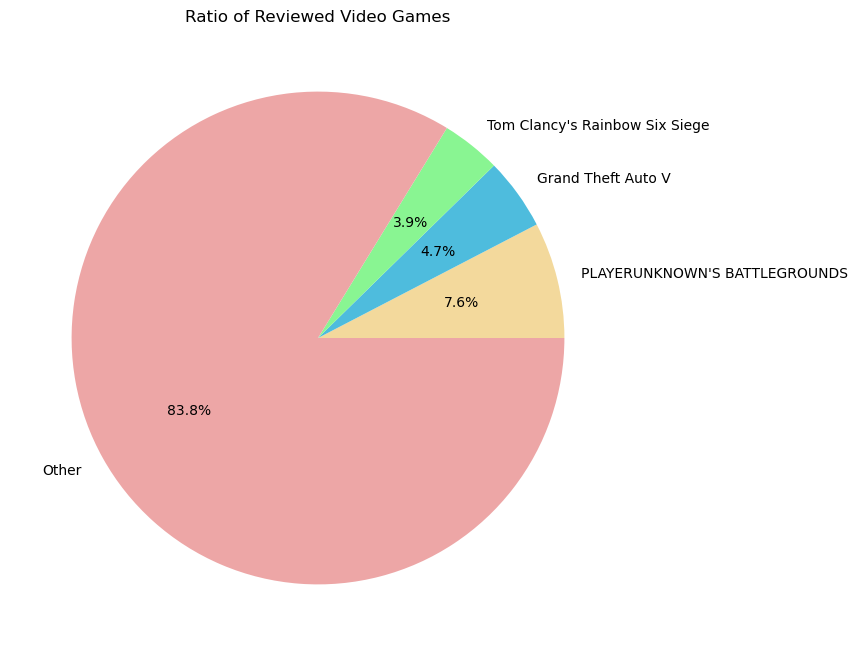

<Figure size 640x480 with 0 Axes>

In [48]:
review_cnts = df['app_name'].value_counts()
top_cnts = review_cnts.head(3)
others_cnts = review_cnts.iloc[3:].sum()

labels = list(top_cnts.index) + ['Other']
sizes = list(top_cnts.values) + [others_cnts]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#f3d99c', '#4ebcdd', '#89f592', '#eda6a6'])
plt.title('Ratio of Reviewed Video Games')

plt.show()
plt.clf()

The above pie chart shows the division of videogames that have been reviewed. **Playerunkown's Battlegrounds** is the most reviewed videogame in our dataset. This also highlights the player base for the video game as well as it's popularity, however no final judgment can be made until we know which video games are also the most recommended.

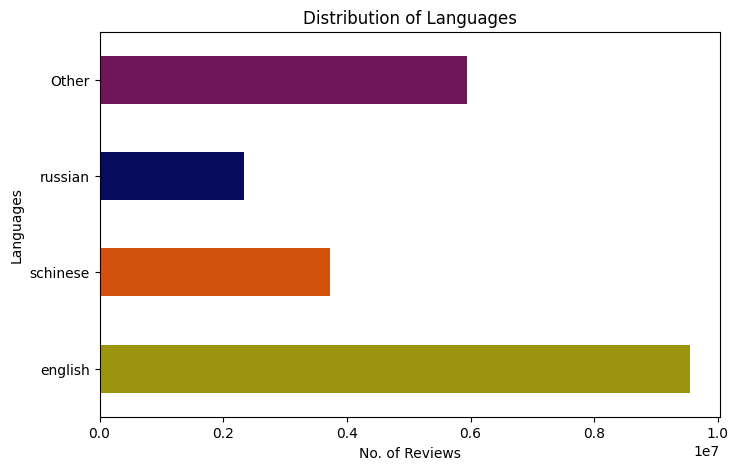

<Figure size 640x480 with 0 Axes>

In [10]:
lang_cnts = df['language'].value_counts()
top_cnts = lang_cnts.head(3)
other_cnts = lang_cnts[~lang_cnts.index.isin(top_cnts.index)].sum()
tot_cnts = pd.concat([top_cnts, pd.Series({'Other': other_cnts})])
plt.figure(figsize=(8, 5))

tot_cnts.plot(kind='barh', color=['#9c940e', '#d1510d', '#070b5e', '#701658'])
plt.title('Distribution of Languages')
plt.ylabel('Languages')
plt.xlabel('No. of Reviews')

plt.show()
plt.clf()

The above bar chart shows the languages the reviews are written in and it clearly shows a large no. of player base that are either natively speak english or prefer english as a language in the video game world.

#### *Univariate Analysis*

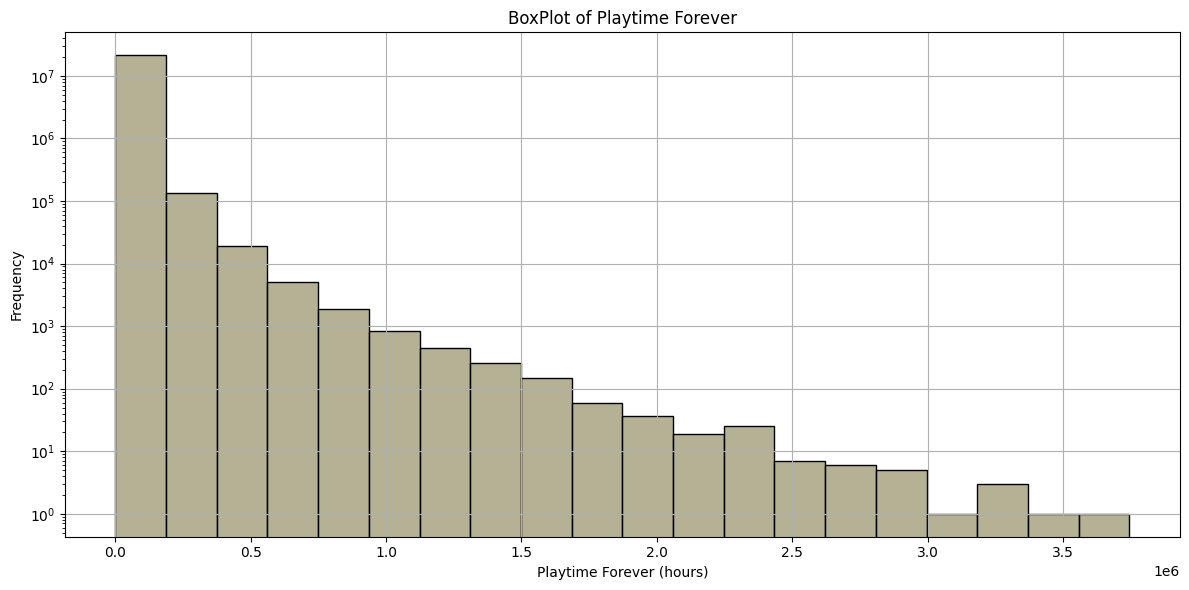

<Figure size 640x480 with 0 Axes>

In [11]:
plt.figure(figsize=(12, 6))
sns.histplot(df['author.playtime_forever'], bins=20, color='#9c9772', edgecolor='black', log=True)

plt.title('BoxPlot of Playtime Forever')
plt.xlabel('Playtime Forever (hours)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()

plt.show()
plt.clf()

The histogram shows us that there is a very high frequency of players who comparitively played the particular videogame for less no. of hours and reviewed that game. The histogram is almost right-skewed with a few complications as we move towards more no. of playtime hours.

#### *Bivariate Analysis*

<Figure size 2000x1500 with 0 Axes>

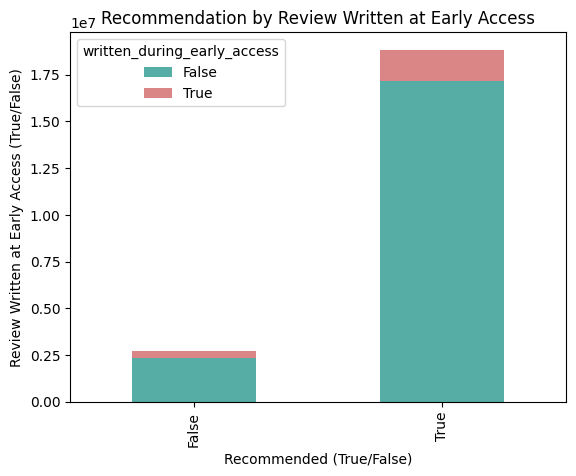

<Figure size 640x480 with 0 Axes>

In [12]:
plt.figure(figsize=(20,15))
pd.crosstab(df['recommended'], df['written_during_early_access']).plot(kind='bar', color=['#55ada5', '#db8686'], stacked=True)

plt.title('Recommendation by Review Written at Early Access')
plt.ylabel('Review Written at Early Access (True/False)')
plt.xlabel('Recommended (True/False)')

plt.show()
plt.clf()

The bar chart shows how likely are people to recommend a videogame based on whether they wrote the review during early access or after full release.  
We can see that more videogames are recommended after the full release rather than during early access. Moreover, same can be said if the videogame is not recommended.
However, comparison between video game being recommended whether it was reviewed in early access or full release is stark as compared to not being recommended under the same conditions.

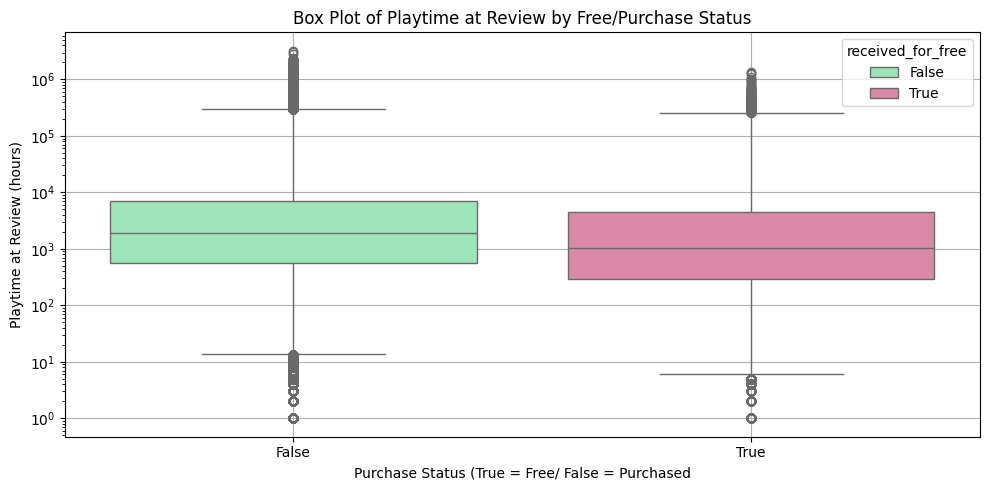

<Figure size 640x480 with 0 Axes>

In [13]:
plt.figure(figsize=(10,5))
sns.boxplot(x='received_for_free', y='author.playtime_at_review', data=df, hue='received_for_free', palette=['#92f0b6', '#e87ba5'], log_scale=True)

plt.title('Box Plot of Playtime at Review by Free/Purchase Status')
plt.ylabel('Playtime at Review (hours)')
plt.xlabel('Purchase Status (True = Free/ False = Purchased')
plt.grid(True)
plt.tight_layout()

plt.show()
plt.clf()

The boxplot indicates that videogames that are purchased (i.e. False) have had more playtime at review by the reviewing playerbase. Moreover, the interquantile range also apears to be higher along y-axis as compared to the interquantile range for videogames received for free. However, it must be noted that there are comparitively more upper and lower outliers for the purchased videogames as compared to the ones received for free.

#### *Timeseries Analysis*


Now let's take a look at some timeseries plots

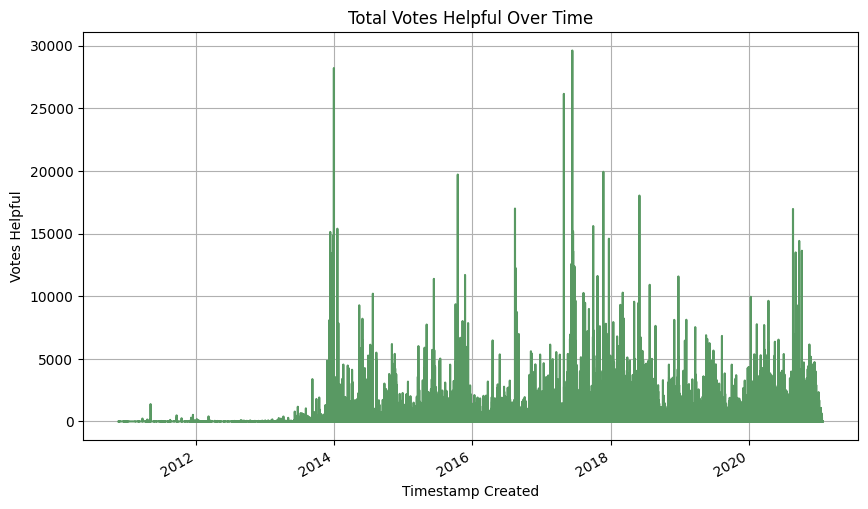

<Figure size 640x480 with 0 Axes>

In [14]:
plt.figure(figsize=(10, 6))
df.groupby('timestamp_created')['votes_helpful'].sum().plot(color='#599963')

plt.title('Total Votes Helpful Over Time')
plt.xlabel('Timestamp Created')
plt.ylabel('Votes Helpful')
plt.grid(True)

plt.show()
plt.clf()

The plot shows that more reviews have been voted helpful around 2014 and at an all time peak of about **3000** somewhere between **2017-18**.

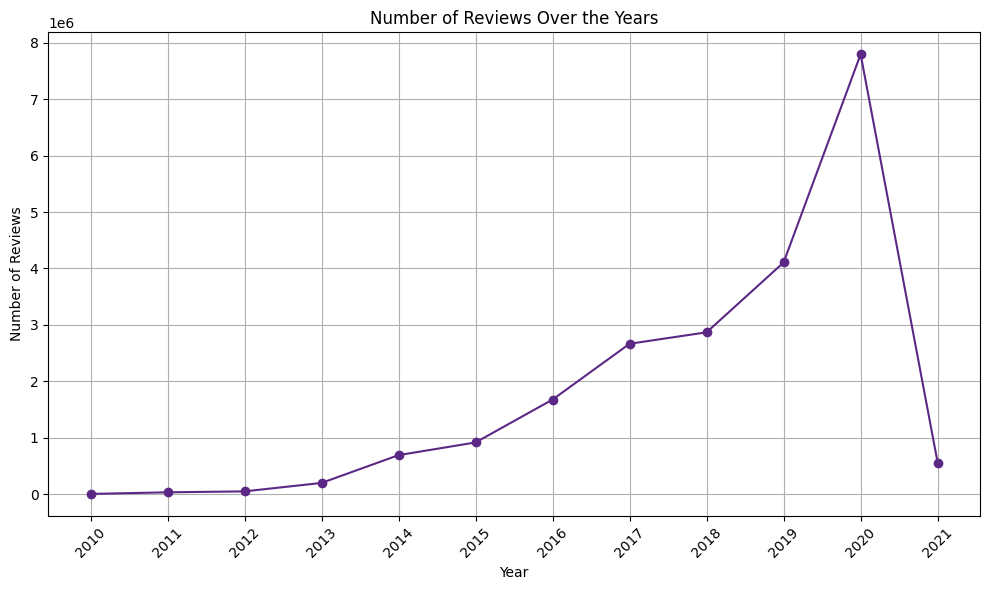

<Figure size 640x480 with 0 Axes>

In [15]:
plt.figure(figsize=(10, 6))
reviews_per_year = df.groupby(df['timestamp_created'].dt.year).size()
reviews_per_year.plot(kind='line', marker='o', color='#5c2885')

plt.title('Number of Reviews Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.xticks(reviews_per_year.index, rotation=45) 
plt.tight_layout()

plt.show()
plt.clf()

The line graph shows a gradual increase in the no. of reviews being done in successive years with an all time peak at the year **2020**. However, the graph shows an abrupt decline in the no. of reviews in the year 2021. We cannot anything with surety about this because the data might not contain data for all the months of the year 2021.

#### *Multivariate Analysis*

Now let's do multivariate analysis for three variables that might provide some interesting readings i.e. `recommended`, `weighted_vote_score` and `author.playtime_at_review`.

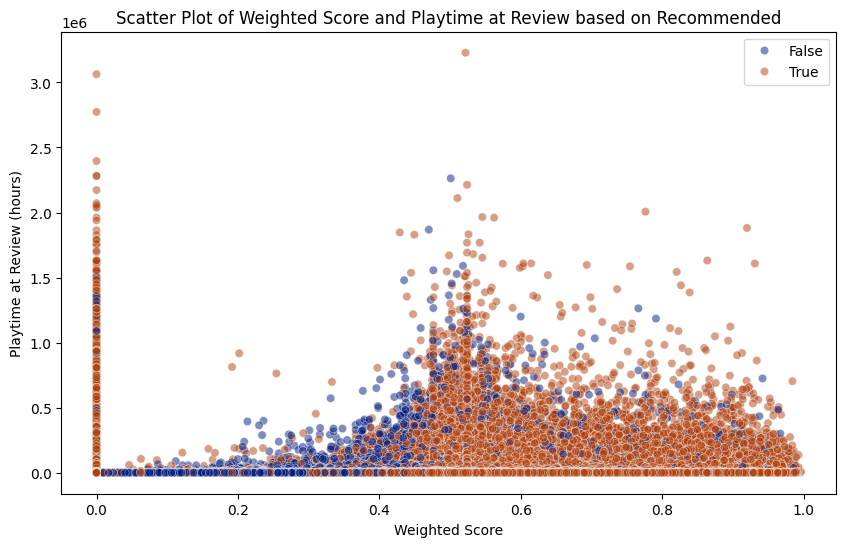

<Figure size 640x480 with 0 Axes>

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='weighted_vote_score', y='author.playtime_at_review', hue='recommended', palette="dark", alpha=0.5).legend(loc='upper right')

plt.title('Scatter Plot of Weighted Score and Playtime at Review based on Recommended')
plt.ylabel('Playtime at Review (hours)')
plt.xlabel('Weighted Score')

plt.show()
plt.clf()

By looking at this scatter plot, we can see that variable `recommended` is **TRUE** for lower values of the variable `author.playtime_at_review`. But it is indicated that the more `weighted_vote_score` a review has, it is more likely to be recommended. 
One nonconforming analysis that comes out of this plot is that if the weighted score is 0, the video game is recommended for almost any no. of playtime hours at the time of review.

#### *Correlation*

In [17]:
df_corr = df[['app_id','review_id', 'timestamp_created', 'timestamp_updated', 'recommended','votes_helpful', 'weighted_vote_score', 
              'comment_count', 'steam_purchase', 'received_for_free', 'written_during_early_access', 'author.steamid', 'author.num_reviews',
               'author.playtime_at_review', 'author.playtime_forever', 'author.last_played']].corr()
             
df_corr

,app_id,review_id,timestamp_created,timestamp_updated,recommended,votes_helpful,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_reviews,author.playtime_at_review,author.playtime_forever,author.last_played
app_id,1.000000,0.371416,0.375922,0.360993,-0.093094,0.003075,-0.027999,-0.005614,-0.008364,0.000381,0.157320,0.094355,-0.016656,-0.083013,-0.087889,0.209645
review_id,0.371416,1.000000,0.972929,0.938467,0.071810,-0.020428,-0.230143,-0.040961,0.073783,0.025942,-0.106491,0.445795,-0.073490,0.009969,-0.072750,0.556042
timestamp_created,0.375922,0.972929,1.000000,0.963913,0.048882,-0.019046,-0.210615,-0.039654,0.074386,0.033900,-0.106433,0.426264,-0.070400,0.023001,-0.053018,0.581851
timestamp_updated,0.360993,0.938467,0.963913,1.000000,0.042153,-0.017463,-0.195535,-0.033981,0.072505,0.032250,-0.117724,0.411895,-0.054495,0.060612,-0.019573,0.598973
recommended,-0.093094,0.071810,0.048882,0.042153,1.000000,-0.027440,-0.182600,-0.048736,-0.000597,0.007552,-0.049181,0.049154,-0.012824,-0.052383,-0.037443,0.090861
votes_helpful,0.003075,-0.020428,-0.019046,-0.017463,-0.027440,1.000000,0.108180,0.474899,-0.004225,-0.001961,0.004413,-0.017753,0.017838,0.006824,0.008548,-0.013704
weighted_vote_score,-0.027999,-0.230143,-0.210615,-0.195535,-0.182600,0.108180,1.000000,0.089079,-0.043052,0.008124,0.051459,-0.155353,0.099111,0.009645,0.046395,-0.110956
comment_count,-0.005614,-0.040961,-0.039654,-0.033981,-0.048736,0.474899,0.089079,1.000000,-0.006233,0.001842,0.007769,-0.026437,0.028283,0.013344,0.019143,-0.024288
steam_purchase,-0.008364,0.073783,0.074386,0.072505,-0.000597,-0.004225,-0.043052,-0.006233,1.000000,-0.127983,0.047909,0.100000,-0.041042,0.002726,0.010282,0.085564
received_for_free,0.000381,0.025942,0.033900,0.032250,0.007552,-0.001961,0.008124,0.001842,-0.127983,1.000000,-0.011424,0.067554,0.001350,-0.011891,-0.007106,0.015232


<Axes: >

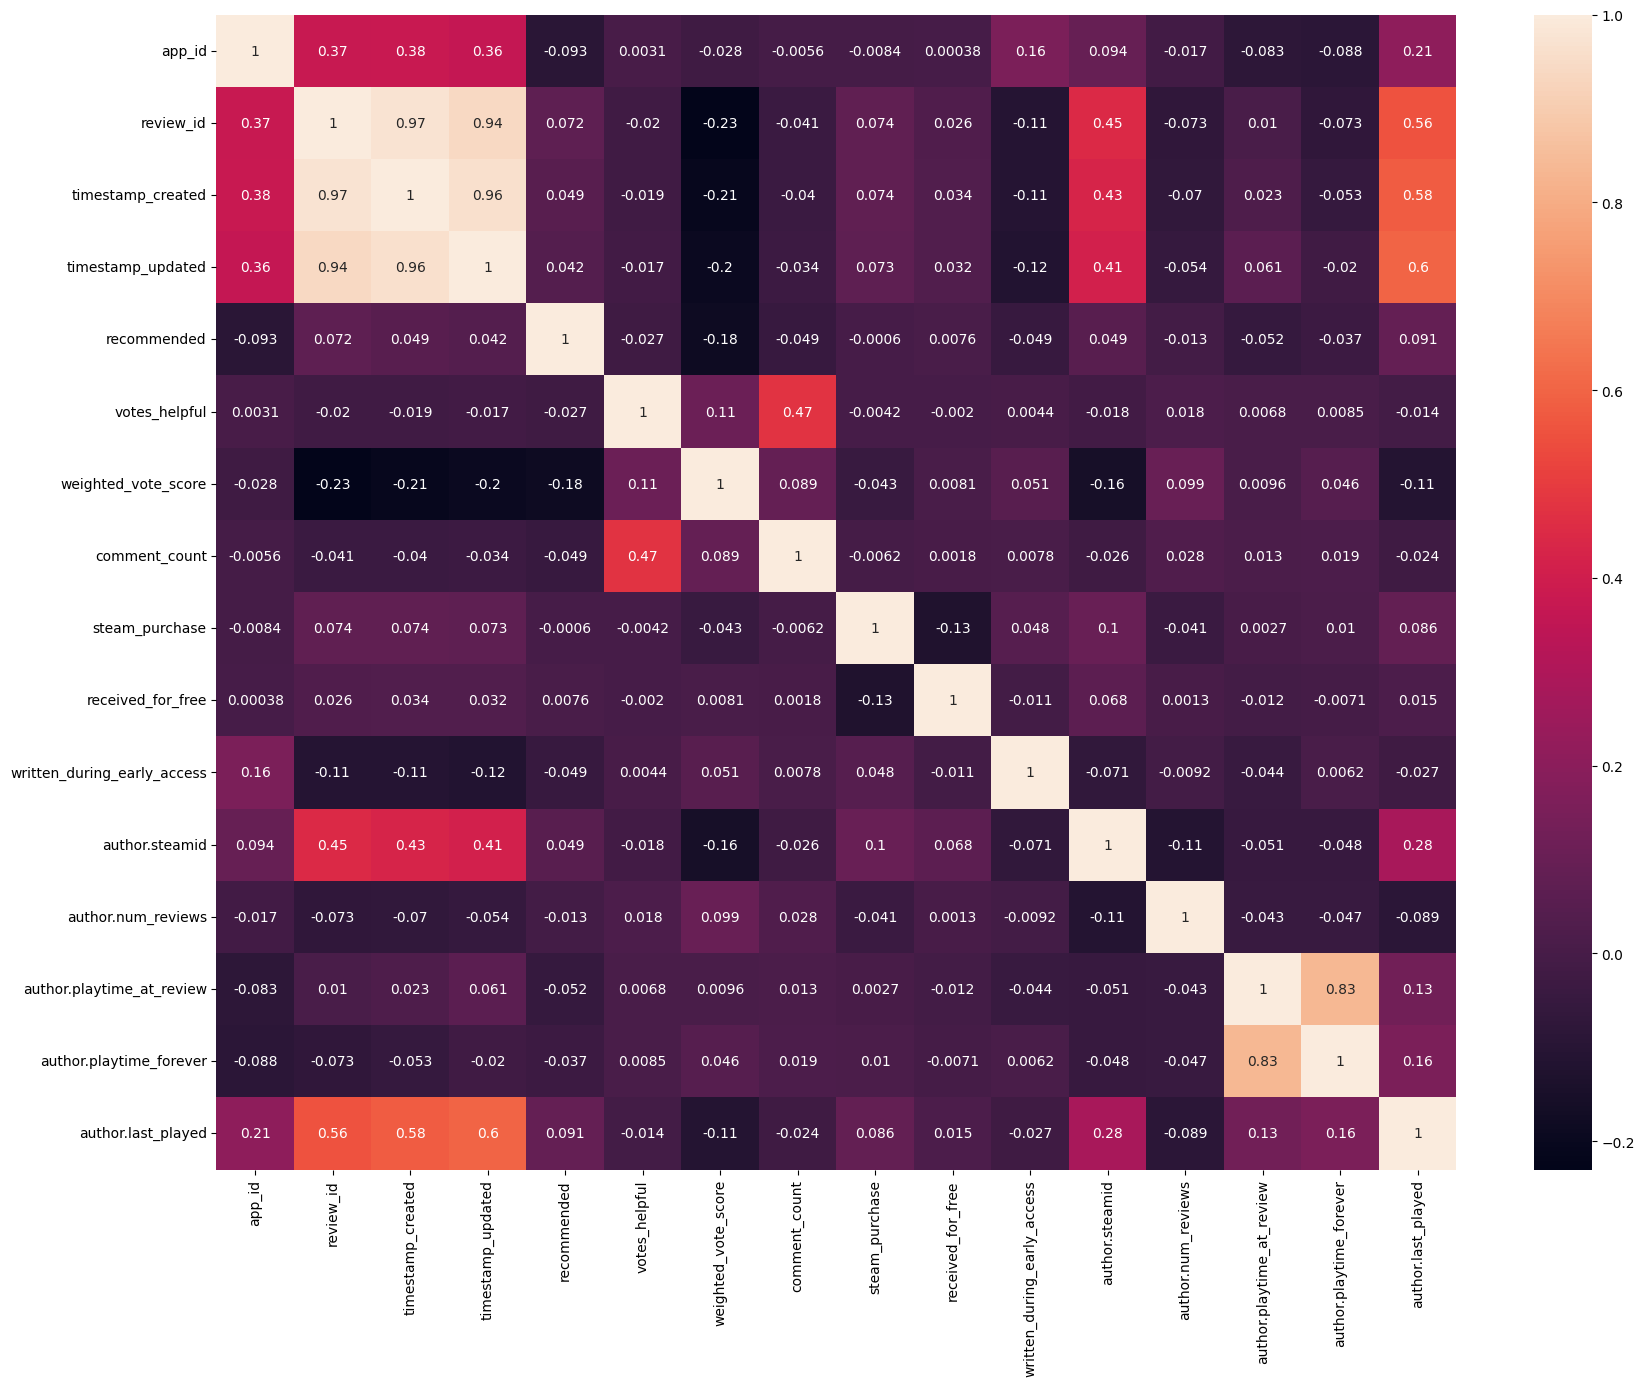

In [18]:
plt.subplots(figsize=(20,15))
sns.heatmap(df_corr, annot=True)

The correlation heatmap shows positive correlation between `review_id`, **timestamp** variables with `author.last_played` variables as well as `author.steamid`.  
Moreover, `comment_count` and `votes_helpful` also show a significant positive correlation of about **0.47**. Both the **playtime** variables show a slight negative correlation with the variable `recommended`.  
However, there seems to be not a very high correlation overall between the variables.

# [RQ2]  Exploring the dataset by analyzing the distribution of reviews across different applications.

- Identify which applications have the highest and lowest number of reviews

In [49]:

# Group by 'app_name' and count the number of reviews
review_counts = df.groupby('app_name')['review_id'].count().reset_index()

# Rename the columns for clarity
review_counts.columns = ['app_name', 'number_of_reviews']

# Sort the applications by the number of reviews in descending order
sorted_reviews = review_counts.sort_values(by='number_of_reviews', ascending=False)

# Identify applications with the highest and lowest number of reviews
highest_reviews = sorted_reviews.head(1)  # Application with the highest reviews
lowest_reviews = sorted_reviews.tail(1)   # Application with the lowest reviews

# Create a PrettyTable for displaying results
table = PrettyTable(["Application Name", "Number of Reviews"])

# highest reviews 
table.add_row([highest_reviews['app_name'].values[0], highest_reviews['number_of_reviews'].values[0]])

# lowest reviews
table.add_row([lowest_reviews['app_name'].values[0], lowest_reviews['number_of_reviews'].values[0]])

# Set horizontal rules for better readability
table.hrules = 1

# Print the table
print(table)


+-------------------------------+-------------------+
|        Application Name       | Number of Reviews |
+-------------------------------+-------------------+
| PLAYERUNKNOWN'S BATTLEGROUNDS |      1642535      |
+-------------------------------+-------------------+
|         Neon Hardcorps        |        197        |
+-------------------------------+-------------------+


- **Plot the Number of Reviews for Each Application in Descending Order**

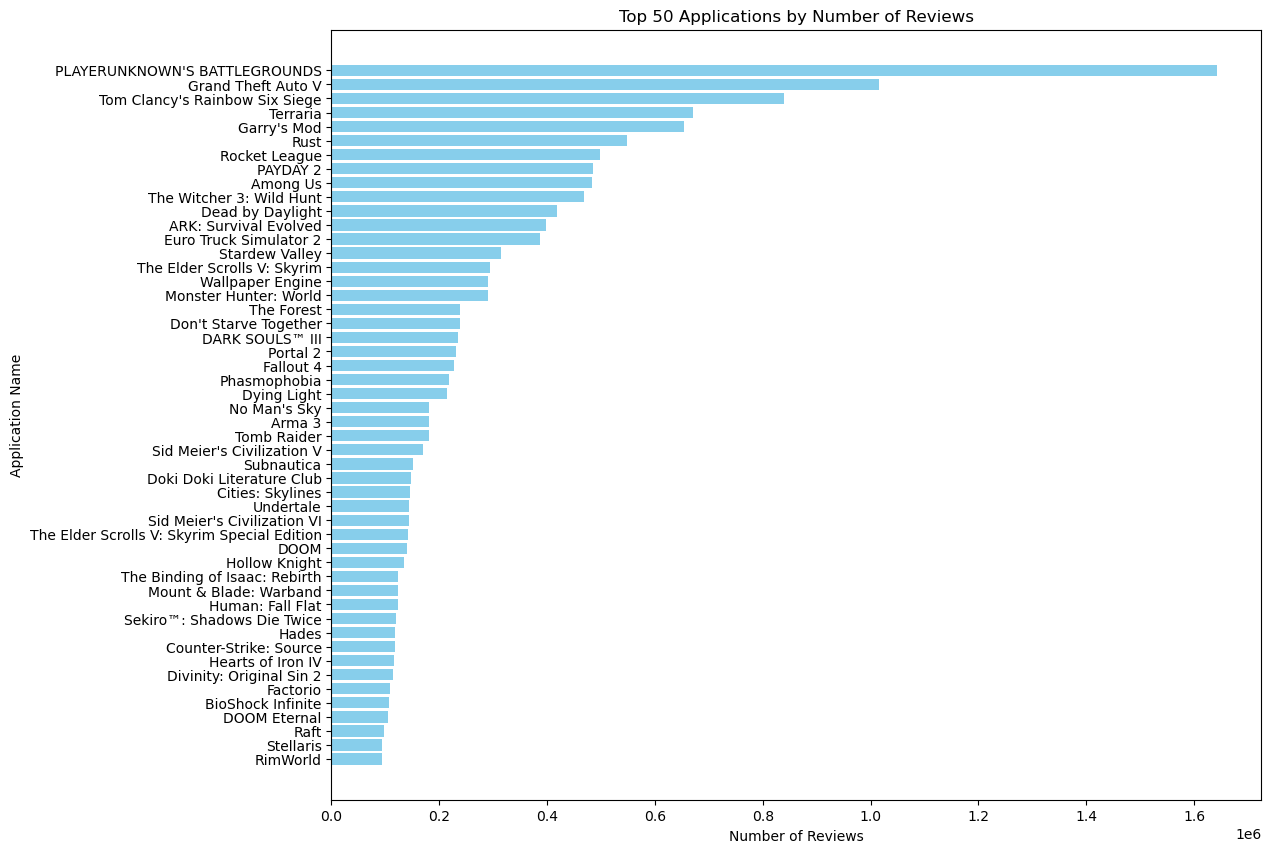

In [50]:
# Group by application name and count the number of reviews
review_counts = df.groupby('app_name').size().reset_index(name='number_of_reviews')

# Sort the DataFrame by the number of reviews in descending order
sorted_reviews = review_counts.sort_values(by='number_of_reviews', ascending=False)

# Get the top 50 applications by number of reviews
top_50_reviews = sorted_reviews.head(50)

# Plotting
plt.figure(figsize=(12, 10))
plt.barh(top_50_reviews['app_name'], top_50_reviews['number_of_reviews'], color='skyblue')
plt.xlabel('Number of Reviews')
plt.ylabel('Application Name')
plt.title('Top 50 Applications by Number of Reviews')
plt.gca().invert_yaxis()  # Invert y-axis to show the application with the most reviews at the top
plt.show()



- For the top 5 applications by number of reviews, how many reviews came from users who purchased the application versus those who received it for free? 
Provide a percentage breakdown and highlight any similarities.

In [51]:
# Group by application name and count the number of reviews
review_counts = df.groupby('app_name').size().reset_index(name='number_of_reviews')

# Sort by number of reviews and get top 5 applications
top_5_apps = review_counts.sort_values(by='number_of_reviews', ascending=False).head(5)

# Filter for the reviews of the top 5 applications
top_5_reviews = df[df['app_name'].isin(top_5_apps['app_name'])]

# Define conditions for calculating purchased and free reviews
# Purchased: steam_purchase is True AND received_for_free is False
# Free: received_for_free is True
purchased_reviews = top_5_reviews[(top_5_reviews['steam_purchase'] == True) & (top_5_reviews['received_for_free'] == False)]
free_reviews = top_5_reviews[top_5_reviews['received_for_free'] == True]

# Group by app_name to get counts for purchased and free reviews
purchased_counts = purchased_reviews.groupby('app_name').size().reset_index(name='purchased_count')
free_counts = free_reviews.groupby('app_name').size().reset_index(name='free_count')

# Merge with total reviews to calculate percentages
total_reviews = top_5_reviews.groupby('app_name').size().reset_index(name='total_reviews')
merged_data = pd.merge(total_reviews, purchased_counts, on='app_name', how='left').fillna(0)
merged_data = pd.merge(merged_data, free_counts, on='app_name', how='left').fillna(0)

# Calculate percentage breakdowns
merged_data['purchased_percentage'] = (merged_data['purchased_count'] / merged_data['total_reviews']) * 100
merged_data['free_percentage'] = (merged_data['free_count'] / merged_data['total_reviews']) * 100

# Display results in a PrettyTable
table = PrettyTable(["Application", "Total Reviews", "Purchased (%)", "Free (%)"])
for index, row in merged_data.iterrows():
    table.add_row([row['app_name'], row['total_reviews'], round(row['purchased_percentage'], 2), round(row['free_percentage'], 2)])
table.hrules = 1
print(table)

# Dynamic insights based on the new data
print("\nKey Insights and Highlights:\n")

# Analyze premium models
premium_apps = merged_data[merged_data['purchased_percentage'] > 70]
if not premium_apps.empty:
    print(f"{len(premium_apps)} applications have high purchased review rates (over 70%).")
    for _, row in premium_apps.iterrows():
        print(f"- **{row['app_name']}**: {round(row['purchased_percentage'], 2)}% purchased reviews")

# Analyze balanced models
balanced_apps = merged_data[(merged_data['purchased_percentage'] >= 40) & (merged_data['purchased_percentage'] <= 60)]
if not balanced_apps.empty:
    print(f"\n{len(balanced_apps)} applications have balanced review distribution (40-60%).")
    for _, row in balanced_apps.iterrows():
        print(f"- **{row['app_name']}**: {round(row['purchased_percentage'], 2)}% purchased, {round(row['free_percentage'], 2)}% free")

# Analyze freemium models
freemium_apps = merged_data[merged_data['free_percentage'] > 30]
if not freemium_apps.empty:
    print(f"\n{len(freemium_apps)} applications rely more on free distribution (>30% free reviews).")
    for _, row in freemium_apps.iterrows():
        print(f"- **{row['app_name']}**: {round(row['free_percentage'], 2)}% free reviews")


+--------------------------------+---------------+---------------+----------+
|          Application           | Total Reviews | Purchased (%) | Free (%) |
+--------------------------------+---------------+---------------+----------+
|          Garry's Mod           |     653543    |     81.42     |   3.78   |
+--------------------------------+---------------+---------------+----------+
|       Grand Theft Auto V       |    1016291    |     85.69     |   3.79   |
+--------------------------------+---------------+---------------+----------+
| PLAYERUNKNOWN'S BATTLEGROUNDS  |    1642535    |     80.84     |   3.74   |
+--------------------------------+---------------+---------------+----------+
|            Terraria            |     671308    |     76.85     |   3.0    |
+--------------------------------+---------------+---------------+----------+
| Tom Clancy's Rainbow Six Siege |     839817    |     80.76     |   4.31   |
+--------------------------------+---------------+--------------

- Which applications have the most and the least user recommendations? Summarizing the findings.

In [52]:
# Group by application name and sum the recommendations
recommendation_counts = df.groupby('app_name')['recommended'].sum().reset_index()

# Rename the column for clarity
recommendation_counts.rename(columns={'recommended': 'total_recommendations'}, inplace=True)

# Sort to find the applications with the most and least recommendations
most_recommended = recommendation_counts.sort_values(by='total_recommendations', ascending=False).head(1)
least_recommended = recommendation_counts.sort_values(by='total_recommendations', ascending=True).head(1)

# Create a PrettyTable instance with border and row separator options
table = PrettyTable()

# Set the column names
table.field_names = ["Application", "Total Recommendations"]

# Add rows for the most and least recommended applications
table.add_row([most_recommended['app_name'].values[0], most_recommended['total_recommendations'].values[0]])
table.add_row([least_recommended['app_name'].values[0], least_recommended['total_recommendations'].values[0]])

# Ensure the table has row borders and full lines separating the data
table.hrules = 1  # Add horizontal rules (row separators)

# Print the table
print(table)

# Summary of findings
most_app = most_recommended['app_name'].values[0]
most_count = most_recommended['total_recommendations'].values[0]
least_app = least_recommended['app_name'].values[0]
least_count = least_recommended['total_recommendations'].values[0]

# Insights
print("\n### Summary of Findings:")
print(f"- **Most Recommended App**: {most_app} with {most_count} recommendations.")
print(f"- **Least Recommended App**: {least_app} with {least_count} recommendations.")

print("\n### Insights:")
print(f"1. Massive Gap: The most recommended app has over {most_count / least_count:.0f} times more recommendations than the least recommended.")
print("2. User Sentiment: High recommendations suggest strong user satisfaction and engagement.")
print("3. Growth Strategy: Encouraging user recommendations can significantly boost an app's visibility and success, especially for lesser-known games.")


+-------------------------------+-----------------------+
|          Application          | Total Recommendations |
+-------------------------------+-----------------------+
| PLAYERUNKNOWN'S BATTLEGROUNDS |         885164        |
+-------------------------------+-----------------------+
|         Neon Hardcorps        |           88          |
+-------------------------------+-----------------------+

### Summary of Findings:
- **Most Recommended App**: PLAYERUNKNOWN'S BATTLEGROUNDS with 885164 recommendations.
- **Least Recommended App**: Neon Hardcorps with 88 recommendations.

### Insights:
1. Massive Gap: The most recommended app has over 10059 times more recommendations than the least recommended.
2. User Sentiment: High recommendations suggest strong user satisfaction and engagement.
3. Growth Strategy: Encouraging user recommendations can significantly boost an app's visibility and success, especially for lesser-known games.


# [RQ3] Understanding when users are most active in submitting reviews can help identify peak engagement periods.

- Plot the number of reviews submitted each month and describe any trends.

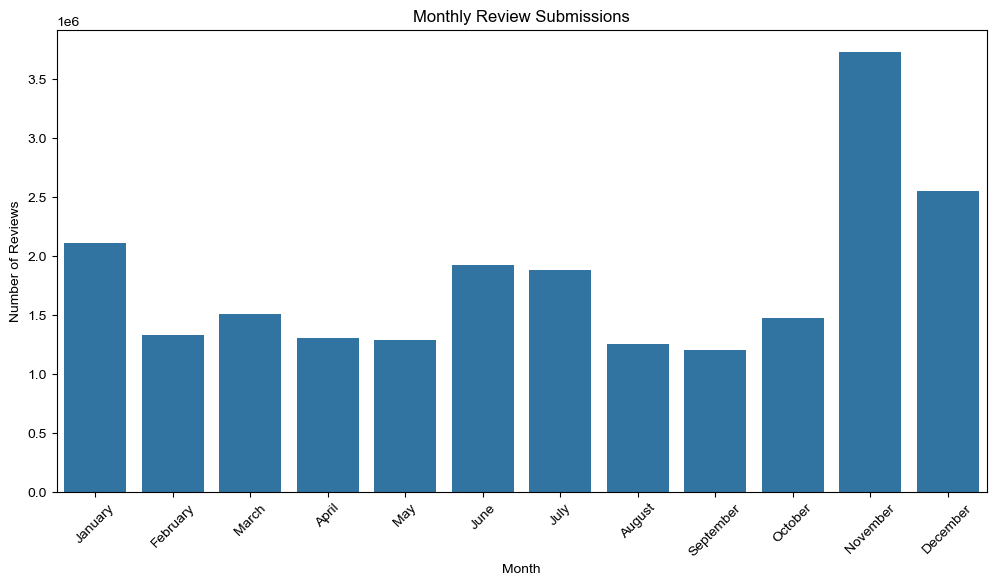

In [110]:

# Extract month name from 'timestamp_created'
df['month'] = df['timestamp_created'].dt.month_name()

# Group by 'month' and count the number of reviews
monthly_reviews = df.groupby('month').size().reset_index(name='number_of_reviews')

# Create a mapping of month names to month numbers for proper sorting
month_order = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Add month numbers to the dataframe
monthly_reviews['month_num'] = monthly_reviews['month'].map(month_order)

# Sort by month number
monthly_reviews = monthly_reviews.sort_values('month_num')

# Plot the monthly review submissions
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='number_of_reviews', data=monthly_reviews)
plt.title('Monthly Review Submissions')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()


- Identify any seasonal patterns or trends in review activity. Explaining seasonal impacts.

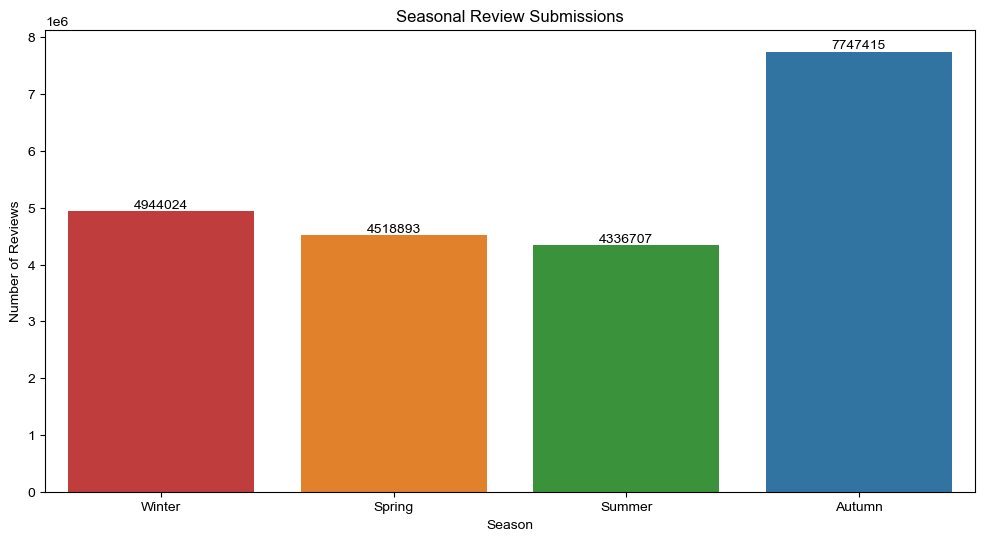

The season with the highest number of reviews is Autumn, with 7747415 reviews. The season with the lowest number of reviews is Summer, with 4336707 reviews. The trend shows an increased user engagement during the fall, which may correlate with certain app releases or holiday periods.


In [115]:
#Identify any seasonal patterns or trends in review activity. Explain any seasonal impact you notice.

# Map quarters to seasons
df['season'] = df['timestamp_created'].dt.quarter.map({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'})

# Group by season and count the number of reviews
seasonal_reviews = df.groupby('season').size().reset_index(name='number_of_reviews')

# Plot seasonal review submissions
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='season', y='number_of_reviews', data=seasonal_reviews, order=['Winter', 'Spring', 'Summer', 'Autumn'], hue='season', dodge=False, legend=False)

# Annotate each bar with the corresponding number of reviews
for i in barplot.containers:
    barplot.bar_label(i, fmt='%d', label_type='edge')

plt.title('Seasonal Review Submissions')
plt.xlabel('Season')
plt.ylabel('Number of Reviews')
plt.show()

# Dynamically generate explanation of seasonal impact
max_season = seasonal_reviews.loc[seasonal_reviews['number_of_reviews'].idxmax(), 'season']
min_season = seasonal_reviews.loc[seasonal_reviews['number_of_reviews'].idxmin(), 'season']
max_reviews = seasonal_reviews['number_of_reviews'].max()
min_reviews = seasonal_reviews['number_of_reviews'].min()

# Explanation of seasonal impact
seasonal_impact = f"The season with the highest number of reviews is {max_season}, with {max_reviews} reviews. The season with the lowest number of reviews is {min_season}, with {min_reviews} reviews. "
if max_season == 'Summer' or max_season == 'Spring':
    seasonal_impact += "This suggests that user activity is higher during the warmer seasons, possibly due to more leisure time and vacations."
elif max_season == 'Winter':
    seasonal_impact += "This indicates that user activity peaks during the colder months, potentially due to more indoor activity."
else:
    seasonal_impact += "The trend shows an increased user engagement during the fall, which may correlate with certain app releases or holiday periods."

print(seasonal_impact)


- Determine if certain times of the year have higher engagement rates. Describe noticeable peaks in user activity.

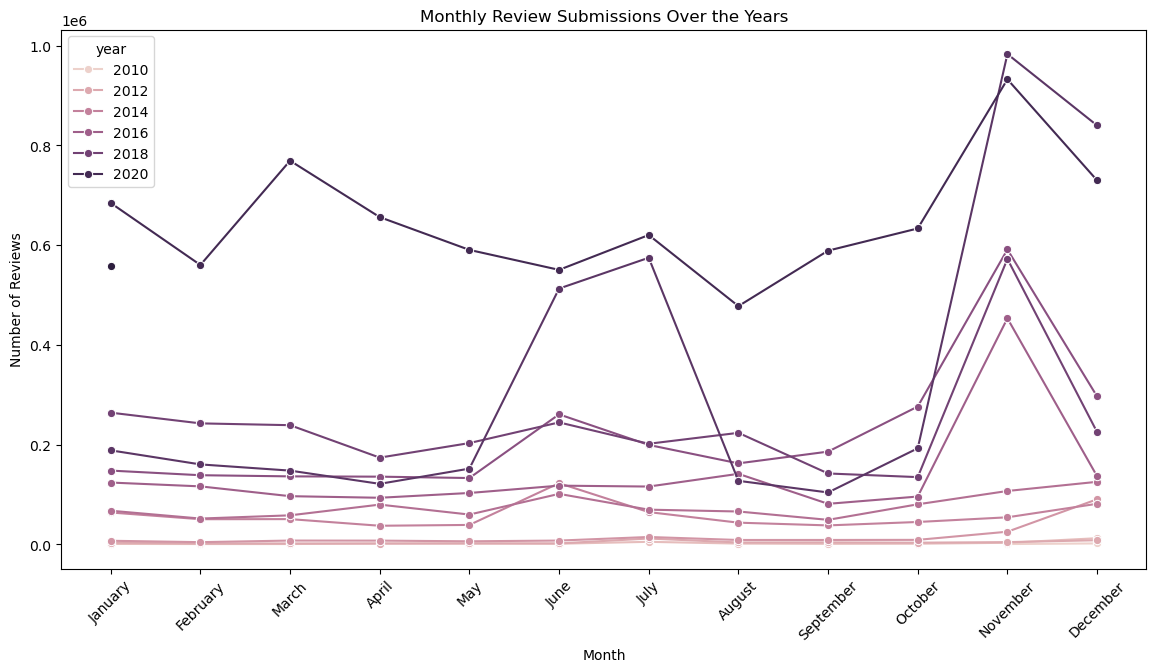

The highest engagement was observed in November of 2019, with 983403 reviews submitted. In contrast, the lowest engagement occurred in November of 2010, with only 550 reviews. The peak during the holiday season suggests users may have more free time or are influenced by year-end promotions and sales. 


In [53]:
# Extract month and year from the timestamp
df['month'] = df['timestamp_created'].dt.month_name()
df['year'] = df['timestamp_created'].dt.year

# Group the data by month and year to analyze user activity over time
monthly_reviews = df.groupby(['year', 'month']).size().reset_index(name='number_of_reviews')

# Sort the data for plotting purposes (month by calendar order, year chronologically)
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_reviews['month'] = pd.Categorical(monthly_reviews['month'], categories=months_order, ordered=True)
monthly_reviews = monthly_reviews.sort_values(by=['year', 'month'])

# Plot the monthly review submissions across different years
plt.figure(figsize=(14, 7))
sns.lineplot(x='month', y='number_of_reviews', hue='year', data=monthly_reviews, marker='o')
plt.title('Monthly Review Submissions Over the Years')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()

# Identify peaks in user activity (times with significantly higher number of reviews)
peak_month = monthly_reviews.loc[monthly_reviews['number_of_reviews'].idxmax(), 'month']
peak_year = monthly_reviews.loc[monthly_reviews['number_of_reviews'].idxmax(), 'year']
peak_reviews = monthly_reviews['number_of_reviews'].max()

# Determine months with the lowest engagement
lowest_month = monthly_reviews.loc[monthly_reviews['number_of_reviews'].idxmin(), 'month']
lowest_year = monthly_reviews.loc[monthly_reviews['number_of_reviews'].idxmin(), 'year']
lowest_reviews = monthly_reviews['number_of_reviews'].min()

# Generate dynamic explanation of engagement peaks
engagement_insight = f"The highest engagement was observed in {peak_month} of {peak_year}, with {peak_reviews} reviews submitted. "
engagement_insight += f"In contrast, the lowest engagement occurred in {lowest_month} of {lowest_year}, with only {lowest_reviews} reviews. "

# Additional observations about peak times
if peak_month in ['June', 'July', 'August']:
    engagement_insight += "The peak activity during the summer months suggests that users are more engaged during vacation or leisure time. "
elif peak_month in ['November', 'December']:
    engagement_insight += "The peak during the holiday season suggests users may have more free time or are influenced by year-end promotions and sales. "
else:
    engagement_insight += "The peak in activity during this month may indicate a release of a popular app or a surge in interest during a specific period."

print(engagement_insight)


- What is the most common time of day users write reviews? For example, users might typically write reviews at 17:44. 
Explain how this time distribution could influence your analysis.

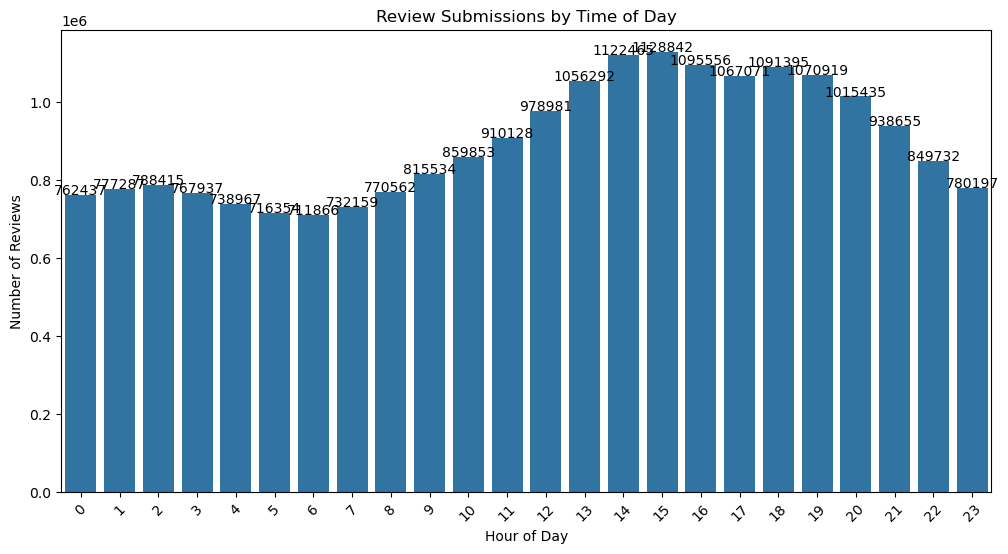

The most common time of day for reviews is 15:00.
The most common time of day for reviews is 15:00. This suggests that users are more active during certain hours of the day. For example, if the peak time is in the evening, it could indicate that users engage with the application after work hours. Understanding these patterns can help target promotions or new releases during peak user activity times.


In [66]:
# Extract the hour from 'timestamp_created'
df['hour'] = df['timestamp_created'].dt.hour

# Find the most common hour for reviews
most_common_hour = df['hour'].mode()[0]

# Group by 'hour' to get the number of reviews submitted each hour
hourly_reviews = df.groupby('hour').size().reset_index(name='number_of_reviews')

# Plot the hourly review submissions
plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='number_of_reviews', data=hourly_reviews)
plt.title('Review Submissions by Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)

# Add values on top of each bar
for i in range(len(hourly_reviews)):
    plt.text(i, hourly_reviews['number_of_reviews'].iloc[i] + 50, str(hourly_reviews['number_of_reviews'].iloc[i]), ha='center')

plt.show()

# Display the most common time of day
print(f"The most common time of day for reviews is {most_common_hour}:00.")

# Explanation of the time distribution’s impact
impact_message = (f"The most common time of day for reviews is {most_common_hour}:00. "
                  "This suggests that users are more active during certain hours of the day. "
                  "For example, if the peak time is in the evening, it could indicate that users engage "
                  "with the application after work hours. Understanding these patterns can help target promotions or new releases during peak user activity times.")
print(impact_message)


- Create a function that accepts a list of time intervals and plots the number of reviews for each interval.
-  Use the function to plot the number of reviews for the following time intervals:

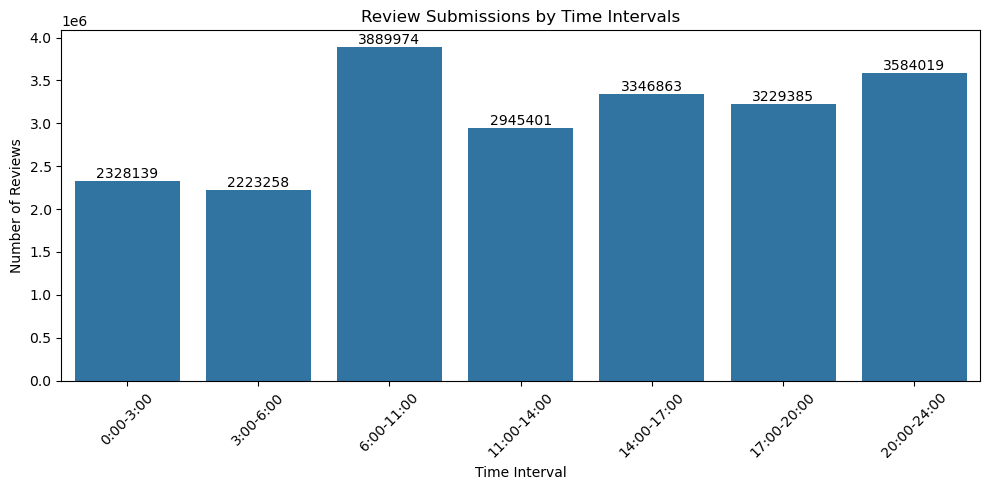

In [71]:
def plot_reviews_by_time_intervals(df, time_intervals):
    # Convert 'timestamp_created' to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(df['timestamp_created']):
        df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], unit='s')
    
    # Extract hour from 'timestamp_created'
    df['hour'] = df['timestamp_created'].dt.hour
    
    # Define time intervals and group by them
    time_labels = [f"{start}:00-{end}:00" for start, end in time_intervals]
    bins = [interval[0] for interval in time_intervals] + [time_intervals[-1][1]]
    df['time_interval'] = pd.cut(df['hour'], bins=bins, labels=time_labels, right=False)
    
    # Count the number of reviews in each time interval
    interval_reviews = df['time_interval'].value_counts().sort_index()
    
    # Plotting
    plt.figure(figsize=(10, 5))
    sns.barplot(x=interval_reviews.index, y=interval_reviews.values)
    plt.title('Review Submissions by Time Intervals')
    plt.xlabel('Time Interval')
    plt.ylabel('Number of Reviews')
    
    # Add values on top of each bar
    for i, val in enumerate(interval_reviews.values):
        plt.text(i, val + 50, str(val), ha='center', va='bottom')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage
time_intervals = [
    (0, 3), (3, 6), (6, 11), 
    (11, 14), (14, 17), (17, 20), 
    (20, 24)
]
plot_reviews_by_time_intervals(df, time_intervals)


#### Saif Ali

### [RQ4] Investigating whether users who spend more time using an application give higher or lower ratings.

* Analyze the relationship between the amount of time a user has spent on an application and their review score.
* Do more experienced users (who have used the application longer) tend to give higher or lower ratings? Comment on any trends you observe.
* Plot the distribution of review scores based on different user experience levels (e.g., new users vs. veteran users). Is there a statistical difference in the score distributions? Use an appropriate statistical test to validate your hypothesis.
* Ask an LLM tool (ChatGPT, Claude AI, etc.) to interpret the statistical results of the analysis and provide potential explanations for the trends. Does the LLM suggest additional factors that could explain why users who spend more time on the app give higher or lower ratings? How can you validate the interpretations provided by the LLM?

##### [RQ4.1]  
Analyze the relationship between the amount of time a user has spent on an application and their review score.

---
To analyse the analyze the relationship between the amount of time ***a user has spent on an application*** and ***their review score***, we first should look for a metric on **review score** in the dataset. Upon examining the EDA, there is no `review_score` or `user_rating` metric ***for a particular user*** (`author.steamid`) to show how he/she rated the application. However, there are scores (like `weighted_vote_score`, `comment_count`, and `votes_helpful`) which we can utilise to devise a **`score_of_review`**, **and not the `review_score` or `rating`** which would tell us how the user rated the application overall (because there is no data about it). 

Before we do, lets see how many applications a single user has played and consequently recommended to understand if we can use `recommended` metric as a score. If `recommended` column is found to be helpful, we can use the following column to devise a `score_of_review` for us:

$$((\text{no. of helpful votes for review} + \text{no. of funny votes for review}) \times (\text{recommended}+1)) \lor \text{recommended}$$

We added a 1 to the recommended because if they do not recommend, atleast we still can see if the review was helpful/funny. 

Keep in mind that because there is no data is provided that can help us to compute rating or review score, our score_of_review metric does not tell how the user rated the review. **It is just, ignoring positive/negative perspective, a score of how others perceive the review**. 


In [1]:
# libraries used throughout the notebook
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from prettytable import PrettyTable

file_path = "/Users/saifdev/desktop/ADM/adm_hw2/steam_reviews.csv"

In [2]:
# loading data with relevant columns
data = pd.read_csv(file_path, usecols=['app_name', 'author.steamid', 'recommended', 'author.playtime_forever', 'app_name', 'votes_helpful', 'votes_funny'])
# examining the shape of the dataframe and also the number of unique owners.
print(f'Shape of the dataframe: {data.shape}')
print(f"Number of unique users: {data['author.steamid'].nunique()}")
ratio = data.shape[0]/data['author.steamid'].nunique()
print(f'Printing the ratio of users to reviews: {ratio}')
print('It means that, as per ratio, we can say that there are users who play more than 1 games and then gave more 1 recommendations.')

Shape of the dataframe: (21747371, 6)
Number of unique users: 12406560
Printing the ratio of users to reviews: 1.7528929050437834
It means that, as per ratio, we can say that there are users who play more than 1 games and then gave more 1 recommendations.


In [3]:
data['recommended'] = data['recommended'].astype(bool)
# Now we will compute the score_of_review using the aforementioned formula
data['score_of_review'] = np.where((data['votes_helpful'] + data['votes_funny']) * (data['recommended']+1) != 0, (data['votes_helpful'] + data['votes_funny']) * (data['recommended']+1), data['recommended'])

In [4]:
data.head()

,app_name,recommended,votes_helpful,votes_funny,author.steamid,author.playtime_forever,score_of_review
0,The Witcher 3: Wild Hunt,True,0,0,76561199095369542,1909.0,1
1,The Witcher 3: Wild Hunt,True,0,0,76561198949504115,2764.0,1
2,The Witcher 3: Wild Hunt,True,0,0,76561199090098988,1061.0,1
3,The Witcher 3: Wild Hunt,True,0,0,76561199054755373,5587.0,1
4,The Witcher 3: Wild Hunt,True,0,0,76561199028326951,217.0,1


In [5]:
score_review = data.groupby(['author.steamid'])['score_of_review'].mean().reset_index(name = 'average_score_review')
print(score_review.head())
score_review.describe()

      author.steamid  average_score_review
0  76561197960265730                 66.00
1  76561197960265745                  3.00
2  76561197960265747                  6.00
3  76561197960265778                  1.50
4  76561197960265781                  1.75


,author.steamid,average_score_review
count,1.240656e+07,1.240656e+07
mean,7.656120e+16,9.639462e+05
std,3.398894e+08,2.501851e+09
min,7.656120e+16,0.000000e+00
25%,7.656120e+16,1.000000e+00
50%,7.656120e+16,1.000000e+00
75%,7.656120e+16,2.000000e+00
max,7.656120e+16,8.796093e+12


In [6]:
# Now we will calculate the average mean time a user played an application:
time_spent = data.groupby(['author.steamid'])['author.playtime_forever'].mean().reset_index(name = 'average_time_spent')
time_spent.head()

,author.steamid,average_time_spent
0,76561197960265730,407.00
1,76561197960265745,7037.50
2,76561197960265747,1842.00
3,76561197960265778,50102.50
4,76561197960265781,4264.25


In [7]:
# RQ 4.1 Analyze the relationship between the amount of time a user has spent on an application
# and their score_of_review

# Merging the data for analysis
analysis = score_review.merge(time_spent, on='author.steamid')
print(analysis.head())

      author.steamid  average_score_review  average_time_spent
0  76561197960265730                 66.00              407.00
1  76561197960265745                  3.00             7037.50
2  76561197960265747                  6.00             1842.00
3  76561197960265778                  1.50            50102.50
4  76561197960265781                  1.75             4264.25


Lets create a scatterplot to see if there is any *relationship* between users who spend more time on an application vs their average score of review

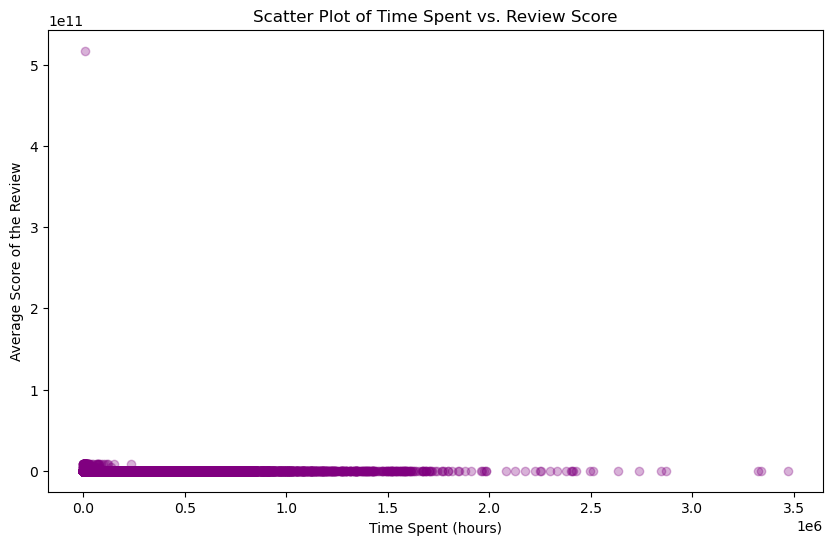

In [8]:
# using a sample of the whole data for computational reasons
sample_data = analysis.sample(frac=0.5) 

# Plot density
plt.figure(figsize=(10, 6))
plt.scatter(x=sample_data['average_time_spent'], y=sample_data['average_score_review'], alpha = 0.3, color ='purple')
plt.title('Scatter Plot of Time Spent vs. Review Score')
plt.xlabel('Time Spent (hours)')
plt.ylabel('Average Score of the Review')
plt.show()


In [9]:
# computing the correlation coefficient between the two variables.
correlation = analysis[['average_time_spent', 'average_score_review']].corr(method='pearson')
print(correlation)

                      average_time_spent  average_score_review
average_time_spent              1.000000             -0.000129
average_score_review           -0.000129              1.000000


The presence of clear couple of horizontal lines indicate that there is no correlation between users who spend more time on an application vs average of whether or not they recommend it (our review score metric). It is also supported by the correlation coefficient which is almost 0.
Even though this contradicts what one might expect (the variables to have a relationship), it turns out that people have a score on their review regardless of the time spent, possibly due to randomness. This suggests that the amount of time a user spends on an application does not significantly influence the perceived helpfulness or quality of their review. 

Several factors could contribute to this observation:
1. **Review Quality**: Users who spend less time on an application might still provide high-quality reviews based on their initial impressions.
2. **Engagement**: Users who spend more time might not necessarily write more helpful reviews, as their engagement could be more focused on gameplay rather than review writing.
3. **Randomness**: The distribution of votes (helpful or funny) might be random and not directly correlated with the time spent on the application.

Further analysis could involve using Sentiment Analysis to actually compute the rating of a user for the application and see if there is a relationship between that rating and number of hours played. Assumably, that is in the bonus quesiton.

##### [RQ4.2] + [RQ4.3]  

* Do more experienced users (who have used the application longer) tend to give higher or lower ratings? Comment on any trends you observe.  
* Plot the distribution of review scores based on different user experience levels (e.g., new users vs. veteran users). Is there a statistical difference in the score distributions? Use an appropriate statistical test to validate your hypothesis.  

To segregate between users who are exprienced and the novice ones, we first have to set a threshold for application usage which would differentiate the two classes.
If we count experience based on the duration of application usage, we can make the following observations:

According to a quick search, [source](https://explodingtopics.com/blog/number-of-gamers), more than 50% of users are below 35 years old. Considering that gamers, on average, spend about 5 hours a day gaming, as supported by [stats](https://www.statista.com/statistics/202839/time-spent-playing-games-by-social-gamers-in-the-us/), we can estimate that an experienced gamer would have spent approximately:

$5 \text{ (gaming for 5 years)} \times 365 \text{ (days in a year)} \times 5 \text{ (hours a day)} \approx 9000$

Using this threshold, we can categorize users into two groups: experienced gamers (those who have spent around 9000 hours or more) and novice gamers (those who have spent less time).

### Analysis Steps:

1. **Define Experienced and Novice Gamers**:
    - Experienced Gamers: Users who have spent approximately 9000 hours or more on the application.
    - Novice Gamers: Users who have spent less than 9000 hours on the application.

2. **Calculate the Average Review Score**:
    - We will use the `votes_helpful` and `votes_funny` columns to devise a `score_of_review` metric.
    - The formula for `score_of_review` is:

    $((\text{no. of helpful votes for review} + \text{no. of funny votes for review}) \times (\text{recommended}+1)) \lor \text{recommended}$
    
    - This metric considers the helpfulness and funniness of the review, along with whether the user recommended the application.

3. **Categorize Users and Analyze Review Scores**:
    - Divide users into experienced and novice groups based on their total playtime.
    - Compare the average review scores between these two groups.

4. **Observe**

In [10]:
# Lets see the distribution of the average_time_spent variable to see if our threshold is realstic
time_spent.average_time_spent.describe()

count    1.240656e+07
mean     1.879897e+04
std      3.899184e+04
min      0.000000e+00
25%      2.061000e+03
50%      6.460500e+03
75%      1.920700e+04
max      3.470649e+06
Name: average_time_spent, dtype: float64

Looking at the median, our threshold of 9e+03 seems realistic to segregated a user as expert or novice based on the `average_time_spent`

In [11]:
score_review = data.groupby(['author.steamid'])['score_of_review'].mean().reset_index(name = 'score_of_review')
time_spent = data.groupby(['author.steamid'])['author.playtime_forever'].mean().reset_index(name = 'average_time_spent')
subset = score_review.merge(time_spent, on='author.steamid')
subset["user_experience"] = np.where(subset['average_time_spent']>=9000, 'Experience', 'Novice')
subset.head()

,author.steamid,score_of_review,average_time_spent,user_experience
0,76561197960265730,66.00,407.00,Novice
1,76561197960265745,3.00,7037.50,Novice
2,76561197960265747,6.00,1842.00,Novice
3,76561197960265778,1.50,50102.50,Experience
4,76561197960265781,1.75,4264.25,Novice


We will now plot the distribution of review scores based on user experience levels


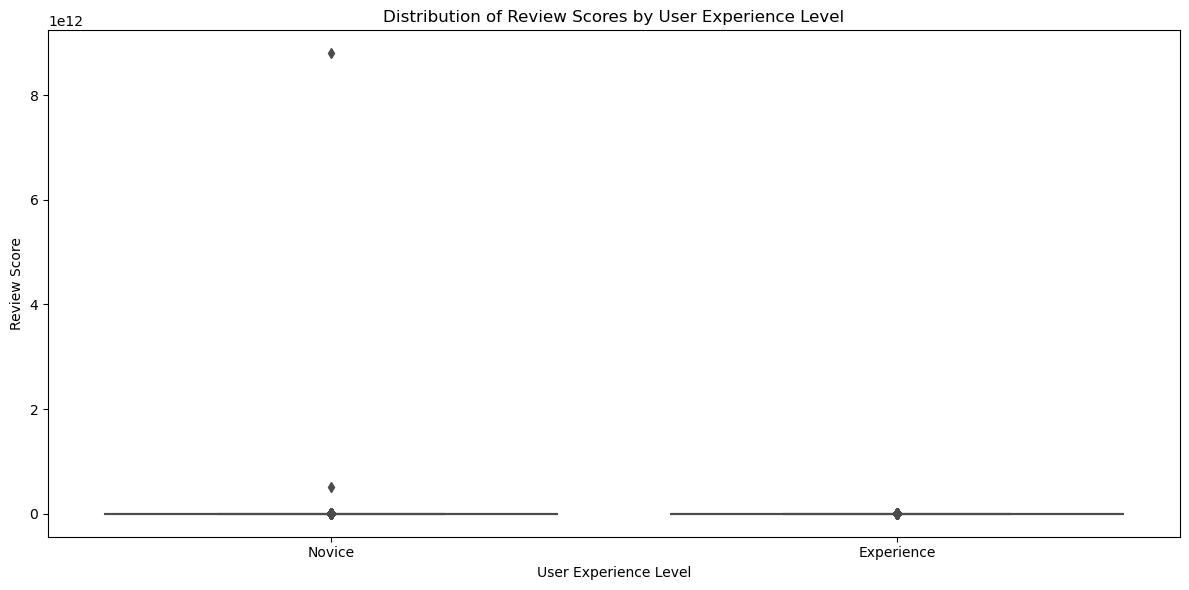

In [12]:
# Plot the distribution of review scores based on user experience levels
plt.figure(figsize=(12, 6))

# Use a count plot or box plot for better visualization
sns.boxplot(x='user_experience', y='score_of_review', data=subset, palette='bright')
plt.title('Distribution of Review Scores by User Experience Level')
plt.xlabel('User Experience Level')
plt.ylabel('Review Score')
plt.tight_layout()
plt.show()

Unfortunately, maybe due to the limited spread of the data, where most score_of_review lies between 0 and 1 and the range of score_of_review is in magnitude > 1e10, it's difficult to precisely pinpoint the quartiles. We can also call the `describe` function and examine potential differences:

In [13]:
novice_scores = subset[subset['user_experience'] == 'Novice']['score_of_review']
experienced_scores = subset[subset['user_experience'] == 'Experience']['score_of_review']

# Create a table
table = PrettyTable()
table.field_names = ["Statistic", "Novice", "Experienced"]

# Add rows to the table
table.add_row(["count", novice_scores.count(), experienced_scores.count()])
table.add_row(["mean", novice_scores.mean(), experienced_scores.mean()])
table.add_row(["std", novice_scores.std(), experienced_scores.std()])
table.add_row(["min", novice_scores.min(), experienced_scores.min()])
table.add_row(["25%", novice_scores.quantile(0.25), experienced_scores.quantile(0.25)])
table.add_row(["50%", novice_scores.quantile(0.5), experienced_scores.quantile(0.5)])
table.add_row(["75%", novice_scores.quantile(0.75), experienced_scores.quantile(0.75)])
table.add_row(["max", novice_scores.max(), experienced_scores.max()])

# Print the table
print(table)

+-----------+--------------------+-------------------+
| Statistic |       Novice       |    Experienced    |
+-----------+--------------------+-------------------+
|   count   |      7198064       |      5208496      |
|    mean   | 1476869.1561486511 | 255094.3728256133 |
|    std    | 3284395781.9934077 |  40412175.8386993 |
|    min    |        0.0         |        0.0        |
|    25%    |        1.0         |        1.0        |
|    50%    |        1.0         |        1.0        |
|    75%    |        1.75        |        2.0        |
|    max    |  8796093022208.0   |    8589934700.0   |
+-----------+--------------------+-------------------+


It turns out that mean of the average_score_of_reviews across the dataset for novice is almost 6 time higher than the experienced ones. But keep in mind that mean is influenced by the outliers too. Looking at the inter quartile range, for the majority and the central fifty percent of the people, the score_of_review is almost distributed the same way across experience level.

However, the result is not surprising given the answer to the previous question 4.1. This could indicate that we have not used the correct metric, and the true answer we were trying to mine is not found. Given the data provided in the dataset, the metric we used was the best possible option.

As for an appropriate statistical test to validate the hypothesis that the two groups are not significantly different, I currently lack the expertise to implement one. Statistical tests come with assumptions about the data, and I would prefer not to conclude something unknown yet. Consequently, I am unable to proceed with the fourth bullet point.

The Pearson correlation coefficient cannot be computed because the novice users and experienced users are different in quantity.


### [RQ5] It is interesting to explore the top reviewers to gain insight into their demographic location, the quality of their reviews, and the applications they tend to review most frequently.

* Determine the ten reviewers with the highest number of reviews in the dataset.
* What is the percentage of each language used by these top 10 reviewers when submitting a review?
* Let's examine whether other users found the reviews from these top 10 reviewers helpful or if they were simply spamming. Calculate the average number of valuable votes these reviewers received for their submitted reviews. Elaborate on the results you see.
* Create a plot showing the distribution of the number of reviews each application received from the top 10 reviewers, arranged in descending order.

##### [RQ5.1] Determine the ten reviewers with the highest number of reviews in the dataset.

In [14]:
# Determine the ten reviewers with the highest number of reviews in the dataset.
data = pd.read_csv(file_path, usecols=['author.steamid', 'app_name', 'author.num_reviews', 'language', 'votes_helpful'])

In [15]:
data.head()

,app_name,language,votes_helpful,author.steamid,author.num_reviews
0,The Witcher 3: Wild Hunt,schinese,0,76561199095369542,2
1,The Witcher 3: Wild Hunt,schinese,0,76561198949504115,10
2,The Witcher 3: Wild Hunt,schinese,0,76561199090098988,1
3,The Witcher 3: Wild Hunt,english,0,76561199054755373,3
4,The Witcher 3: Wild Hunt,schinese,0,76561199028326951,4


In [16]:
# checking if the author.num_reviews is consistent for one example
data.loc[data['author.steamid']==76561198045381877, 'author.num_reviews']

60131       2378
523650      2374
621022      2374
849302      2374
903774      2374
            ... 
21393636    2377
21461108    2377
21587813    2374
21621775    2377
21692708    2377
Name: author.num_reviews, Length: 103, dtype: int64

Turns out that author.num_reviews varies, but no greatly. When grouping the data, we will use the max() to get the maximum number of reviews a user has ever given.

In [17]:
tot_num_rev = data.groupby('author.steamid')['author.num_reviews'].max().reset_index(name = 'num_reviews')

In [18]:
# Determine the ten reviewers with the highest number of reviews in the dataset.
top_10 = tot_num_rev.sort_values(by=['num_reviews'], ascending=False).head(10)

# Create a PrettyTable instance
table = PrettyTable()

# Set the column names
table.field_names = ["Author SteamID", "Number of Reviews"]

# Add rows
for index, row in top_10.iterrows():
    table.add_row([row['author.steamid'], row['num_reviews']])

print('Printing the Top 10 reviewers with the highest number of reviews in the dataset')
print(table)

+-------------------+-------------------+
|   Author SteamID  | Number of Reviews |
+-------------------+-------------------+
| 76561198103272004 |   4398046511108   |
| 76561198848008157 |   4398046511105   |
| 76561198125392509 |        5236       |
| 76561198135438892 |        5148       |
| 76561198116879965 |        4795       |
| 76561197960373660 |        4137       |
| 76561198057389389 |        3775       |
| 76561198030784015 |        3473       |
| 76561197974092119 |        3468       |
| 76561198172925593 |        3216       |
+-------------------+-------------------+


##### [RQ5.2]  
What is the percentage of each language used by these top 10 reviewers when submitting a review?

* Assuming the percentage used of each language refers to collective use each language by all top 10 users!

In [19]:
# Get the list of steam IDs for the top 10 reviewers
top_10_steamids = top_10['author.steamid'].tolist()

# Filter the data to include only reviews from the top 10 reviewers
top_10_data = data.loc[data['author.steamid'].isin(top_10_steamids)]

# Group the filtered data by language and count the number of reviews for each language
top_10_data_lang = top_10_data.groupby('language')['author.steamid'].count()

# Compute the percentage of each language used by the top 10 reviewers
total_reviews_top_10 = top_10_data_lang / top_10_data_lang.sum() * 100

# Create a PrettyTable instance
table = PrettyTable()

# Set the column names
table.field_names = ["Language", "Percentage (%)"]

# Add rows
for index, value in total_reviews_top_10.items():
    table.add_row([index, f"{value:.1f}%"])

# Print the table
print(table)

+----------+----------------+
| Language | Percentage (%) |
+----------+----------------+
| english  |     50.2%      |
| japanese |      0.4%      |
|  latam   |      0.4%      |
|  polish  |     22.6%      |
| romanian |      9.5%      |
| russian  |     14.0%      |
| schinese |      2.9%      |
+----------+----------------+


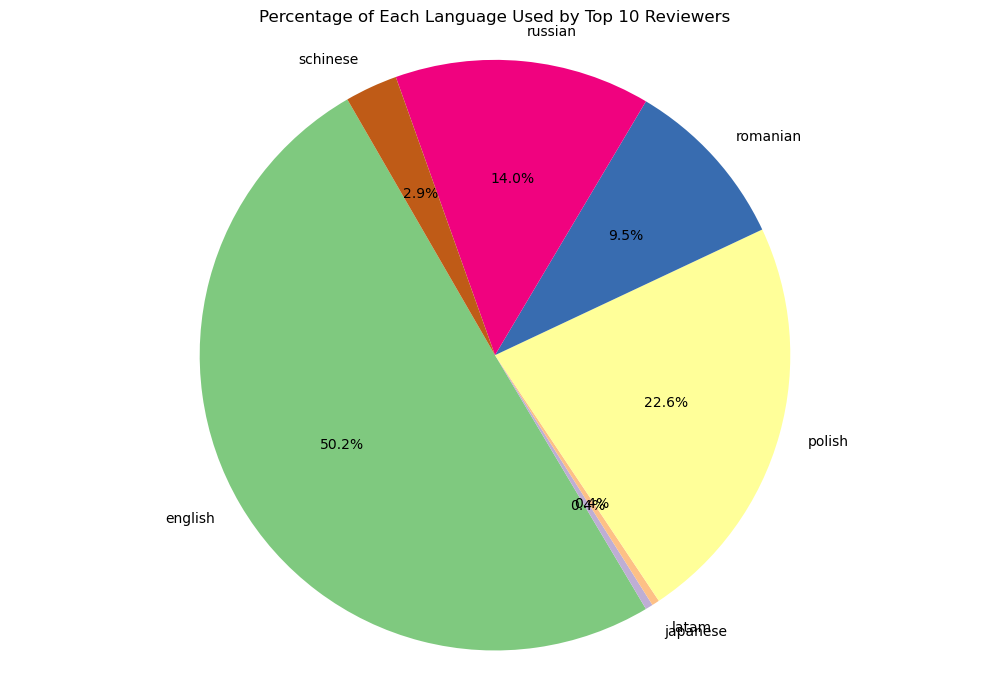

In [20]:
# Plotting the pie chart
plt.figure(figsize=(10, 7))
plt.pie(total_reviews_top_10, labels=total_reviews_top_10.index, autopct='%1.1f%%', startangle=120, colors=plt.cm.Accent.colors)
plt.title('Percentage of Each Language Used by Top 10 Reviewers')
plt.tight_layout()
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

##### RQ[5.3]  
Let's examine whether other users found the reviews from these top 10 reviewers helpful or if they were simply spamming. Calculate the average number of valuable votes these reviewers received for their submitted reviews. Elaborate on the results you see.

In [21]:
# Filter the data to include only reviews from the top 10 reviewers
top_10_data = data.loc[data['author.steamid'].isin(top_10_steamids)]

# Group the filtered data by 'author.steamid' and calculate the average number of helpful votes for each reviewer
avg_votes_helpful = top_10_data.groupby('author.steamid')['votes_helpful'].mean()

# Display the average number of helpful votes for each of the top 10 reviewers
print(avg_votes_helpful)

author.steamid
76561197960373660     6.040816
76561197974092119     7.727273
76561198030784015     0.944444
76561198057389389     0.285714
76561198103272004     0.000000
76561198116879965    10.205882
76561198125392509     1.625000
76561198135438892     0.173913
76561198172925593    11.714286
76561198848008157     0.000000
Name: votes_helpful, dtype: float64


Analysis of Average Number of Valuable Votes for Top 10 Reviewers

We have calculated the average number of valuable votes (i.e., votes marked as helpful) received by the top 10 reviewers for their submitted reviews. The results are as follows:

| Author SteamID     | Average Votes Helpful |
|--------------------|-----------------------|
| 76561197960373660  | 6.04                  |
| 76561197974092119  | 7.73                  |
| 76561198030784015  | 0.94                  |
| 76561198057389389  | 0.29                  |
| 76561198103272004  | 0.00                  |
| 76561198116879965  | 10.21                 |
| 76561198125392509  | 1.63                  |
| 76561198135438892  | 0.17                  |
| 76561198172925593  | 11.71                 |
| 76561198848008157  | 0.00                  |

Observations:

1. **High Variability**: There is a significant variability in the average number of helpful votes received by the top 10 reviewers. Some reviewers, such as `76561198172925593` and `76561198116879965`, receive a high average number of helpful votes (11.71 and 10.21, respectively), indicating that their reviews are generally well-received by the community. While one has 0 as votes helpful, like the user `76561198103272004`

2. **Low Engagement**: On the other hand, several reviewers receive low helpful votes on average, suggesting that their reviews might not be as valuable or engaging to other users.

3. **Moderate Engagement**: Reviewers like `76561197960373660` and `76561197974092119` have a moderate number of helpful votes (6.04 and 7.73, respectively), indicating a balanced reception from the community.

4. **Potential Spamming**: Reviewers with very low average helpful votes, such as average votes helpful < 2, might be submitting reviews that are not considered valuable by other users, potentially indicating spamming behavior.

Conclusion:
The analysis shows a mixed reception for the reviews submitted by the top 10 reviewers. While some reviewers consistently provide valuable insights, others may need to improve the quality of their reviews to better engage with the community.

##### [RQ5.4]

Create a plot showing the distribution of the number of reviews each application received from the top 10 reviewers, arranged in descending order.

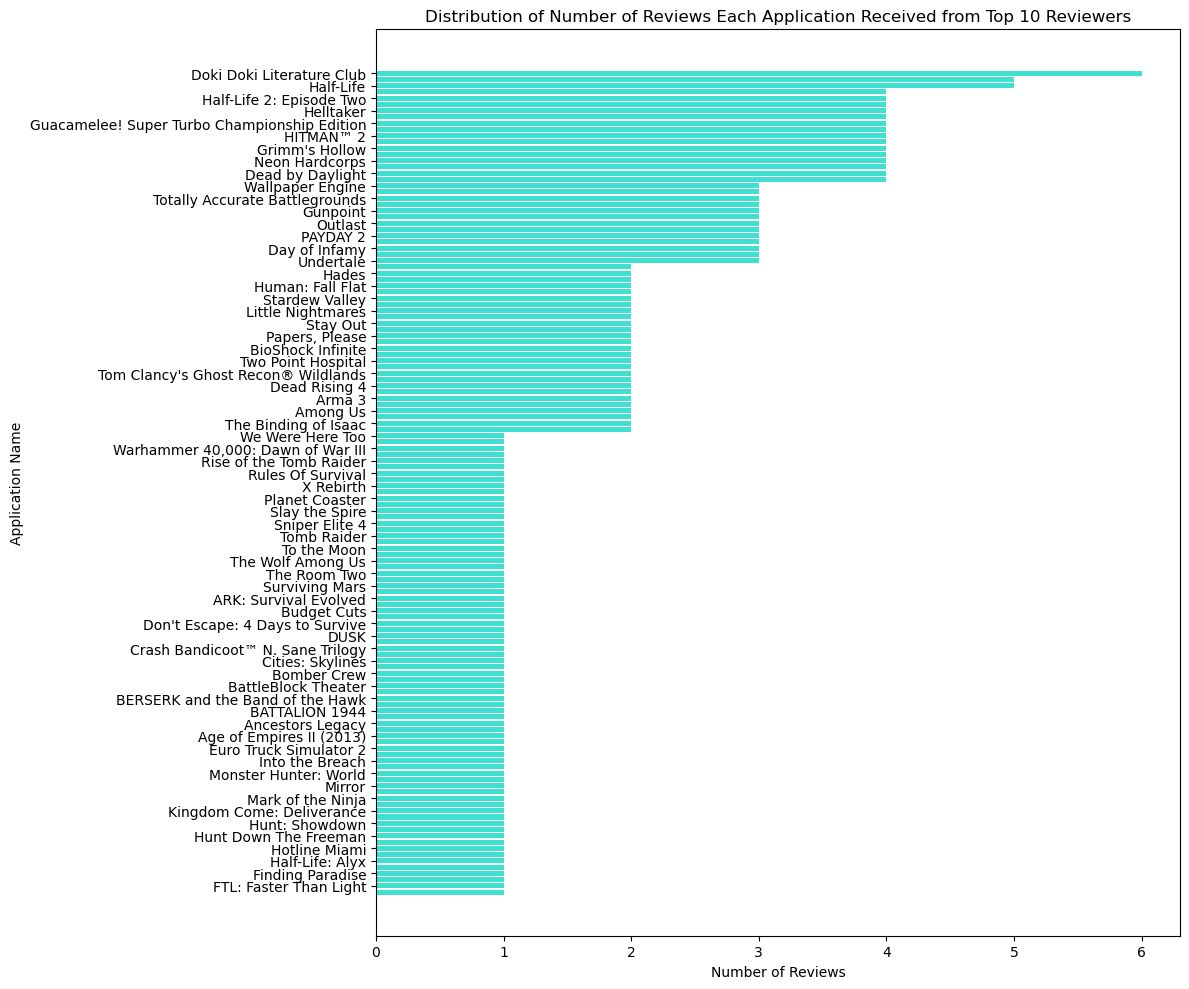

In [24]:
# Group by application name and count the number of reviews from the top 10 reviewers
app_review_counts = top_10_data.groupby('app_name')['author.steamid'].count().reset_index(name='number_of_reviews')

# Sort the DataFrame by the number of reviews in descending order
sorted_app_reviews = app_review_counts.sort_values(by='number_of_reviews', ascending=False)

# Plot
plt.figure(figsize=(12, 10))
plt.barh(sorted_app_reviews['app_name'], sorted_app_reviews['number_of_reviews'], color='turquoise')
plt.xlabel('Number of Reviews')
plt.ylabel('Application Name')
plt.title('Distribution of Number of Reviews Each Application Received from Top 10 Reviewers')
plt.gca().invert_yaxis() # from higher values to lower values

# Only display every other label to reduce clutter
plt.yticks(sorted_app_reviews['app_name'][::2], fontsize=10)
plt.tight_layout()
plt.show()
